In [261]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [4]:
df_import = pd.read_csv('arquivos\dadosalunos-limpo.csv')

C:\Users\romul\AppData\Local\Temp\ipykernel_9372\3102232277.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_import = pd.read_csv('arquivos\dadosalunos-limpo.csv')


In [5]:
df_import.columns

Index(['ANO_OCORRENCIA', 'CD_ALUNO', 'CD_CURSO', 'CD_ORIGEM_ALUNO', 'CD_TURNO',
       'DE_NATURALIDADE', 'DH_MATRICULA', 'DH_SITUACAO', 'DT_ANO_INGRES',
       'DT_NASC_ALUNO', 'LT_ESTADO_CIVIL', 'LT_MODALIDADE', 'LT_NACIONALIDADE',
       'LT_RACA', 'NM_CIDADE_AULA', 'NM_CIDADE_EST2GRAU', 'NM_CIDADE_FERIAS',
       'NM_CIDADE_NASC', 'NM_PAIS_NASC', 'NU_SEMESTRE2_VEST', 'SG_SEXO_ALUNO',
       'SG_UF_AULA', 'SG_UF_EST2GRAU', 'SG_UF_FERIAS', 'SG_UF_NASC_ALUNO',
       'ST_ALUNO', 'TP_DEFIC_INEP', 'TP_ESCOLA', 'TP_INGRES_CURSO',
       'TP_OPCAO_COTAS', 'F_CD_ORIGEM_ALUNO', 'F_DT_NASC_ALUNO',
       'F_NM_PAIS_NASC', 'F_NU_SEMESTRE2_VEST', 'F_SG_UF_FERIAS',
       'F_SG_UF_NASC_ALUNO', 'BOOL_TRANCADO', 'BOOL_ST_ALUNO',
       'MULTI_ST_ALUNO', 'BOOL_DEFIC_INEP', 'F_TP_ESCOLA', 'F_TP_OPCAO_COTAS',
       'BOOL_COTAS', 'IDADE_MATRICULA', 'ANO_NASCIMENTO',
       'MESES_ATE_ULTIMA_SITUACAO', 'NM_CURSO', 'TP_HABILITACAO', 'SG_CENTRO',
       'NM_CAMPUS', 'MAX_ANOS', 'BOOL_SEDE', 'LOCAL_FERI

In [6]:
colunas_excluir_ml = ['NM_CAMPUS', 
                      'SG_CENTRO', 
                      'NM_CURSO',
                      'GERACAO_COMPLETA', 
                      'NUMERO_GERACAO', 
                      'BOOL_ST_ALUNO', 
                      'MULTI_ST_ALUNO']
colunas_ml = ['CD_CURSO',
         'CD_TURNO',
         'LT_ESTADO_CIVIL',
         'LT_RACA',
         'F_NU_SEMESTRE2_VEST',
         'SG_SEXO_ALUNO',
         'BOOL_DEFIC_INEP',
         'F_TP_ESCOLA',
         'BOOL_COTAS',
         'IDADE_MATRICULA',
         'LOCAL_FERIAS',
         'LOCAL_NASC']
target_bool = 'BOOL_ST_ALUNO'
target_multi = 'MULTI_ST_ALUNO'

In [7]:
df = df_import[colunas_ml + colunas_excluir_ml].copy()

In [8]:
df = df.dropna()
df.shape[0]

66820

In [9]:
df['BOOL_ST_ALUNO'].value_counts(), df['BOOL_ST_ALUNO'].value_counts(normalize=True)

(BOOL_ST_ALUNO
 0.0    42487
 1.0    24333
 Name: count, dtype: int64,
 BOOL_ST_ALUNO
 0.0    0.635843
 1.0    0.364157
 Name: proportion, dtype: float64)

### Preparação do Dataset

In [10]:
pd.cut(df['IDADE_MATRICULA'], bins=[0, 16, 18, 20, 22, 24, 26, 30, 40, 50, 60, 70]).value_counts()

IDADE_MATRICULA
(16, 18]    36249
(18, 20]    14251
(20, 22]     5671
(22, 24]     3226
(26, 30]     2130
(24, 26]     1879
(30, 40]     1786
(0, 16]       935
(40, 50]      554
(50, 60]      128
(60, 70]       10
Name: count, dtype: int64

In [11]:
df['IDADE_MATRICULA'] = pd.cut(df['IDADE_MATRICULA'], bins=[0, 16, 18, 20, 22, 24, 26, 30, 40, 50, 60, 70]).value_counts()

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
for coluna in colunas_ml:
    le = LabelEncoder()
    df[coluna] = le.fit_transform(df[coluna])

In [14]:
df.shape[0]

66820

In [15]:
df['CD_CURSO'].nunique()

45

#### Jubilados antes do tempo mínimo

In [14]:
df_import[df_import['GERACAO_COMPLETA'] == 0]['MULTI_ST_ALUNO'].value_counts()

MULTI_ST_ALUNO
CANCELAMENTO     9010
MATRICULADO      8645
FORMADO          6562
TRANSFERENCIA     185
JUBILADO          169
Name: count, dtype: int64

In [113]:
df_import['DT_ANO_INGRES'].value_counts().sort_index()

DT_ANO_INGRES
2002    2202
2003    2725
2004    2751
2005    2845
2006    3007
2007    3186
2008    4066
2009    4085
2010    3512
2011    3567
2012    3379
2013    3519
2014    3373
2015    3214
2016    2932
2017    3036
2018    3148
2019    3110
2020    3282
2021    2945
2022    2936
Name: count, dtype: int64

In [167]:
jubilados_antes = df_import[(df_import['GERACAO_COMPLETA'] == 0) & (df_import['MULTI_ST_ALUNO'] == 'JUBILADO')]

In [169]:
jubilados_antes['DT_ANO_INGRES'].value_counts().sort_index()

DT_ANO_INGRES
2014    11
2015    55
2016    37
2017    26
2018    13
2019    20
2020     5
2021     2
Name: count, dtype: int64

In [178]:
jubilados_antes['ANO_ULTIMA_SITUACAO'] = pd.to_datetime(jubilados_antes['DH_SITUACAO']).apply(lambda x: x.year)
jubilados_antes['ANO_MATRICULA'] = pd.to_datetime(jubilados_antes['DH_MATRICULA']).apply(lambda x: x.year)

C:\Users\romul\AppData\Local\Temp\ipykernel_22360\3919423426.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jubilados_antes['ANO_ULTIMA_SITUACAO'] = pd.to_datetime(jubilados_antes['DH_SITUACAO']).apply(lambda x: x.year)
C:\Users\romul\AppData\Local\Temp\ipykernel_22360\3919423426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jubilados_antes['ANO_MATRICULA'] = pd.to_datetime(jubilados_antes['DH_MATRICULA']).apply(lambda x: x.year)


In [174]:
jubilados_antes['ANO_ULTIMA_SITUACAO'].value_counts().sort_index()

ANO_ULTIMA_SITUACAO
2017    12
2018    20
2019    25
2020    15
2021    16
2022    15
2023    66
Name: count, dtype: int64

In [183]:
jubilados_antes.groupby(['MAX_ANOS', 'ANO_MATRICULA', 'ANO_ULTIMA_SITUACAO'])['CD_ALUNO'].count()

MAX_ANOS  ANO_MATRICULA  ANO_ULTIMA_SITUACAO
7         2016           2021                    1
                         2023                   12
          2018           2023                    1
8         2015           2017                   12
                         2018                    7
                         2019                    1
                         2020                    1
                         2023                   34
          2016           2018                   13
                         2019                   11
          2017           2019                   13
                         2020                   11
                         2022                    1
                         2023                    1
          2018           2020                    3
                         2021                    9
          2019           2021                    6
                         2022                   10
                         2023        

In [107]:
df_import['ANO_ULTIMA_SITUACAO'] = pd.to_datetime(df_import['DH_SITUACAO']).apply(lambda x: x.year)

In [115]:
df_import['ANO_ULTIMA_SITUACAO'].value_counts().sort_index()

ANO_ULTIMA_SITUACAO
2002    1700
2003    1097
2004     421
2005     212
2006      75
2007     808
2008    3649
2009    3613
2010    4864
2011    3781
2012    2122
2013    4077
2014    3209
2015    3415
2016    3214
2017    3499
2018    3653
2019    4302
2020    4690
2021    5240
2022    5828
2023    3351
Name: count, dtype: int64

In [117]:
df_import[df_import['ANO_ULTIMA_SITUACAO'] == 2023]['MULTI_ST_ALUNO'].value_counts()

MULTI_ST_ALUNO
FORMADO          1603
CANCELAMENTO     1172
MATRICULADO       429
JUBILADO          100
TRANSFERENCIA      47
Name: count, dtype: int64

### Funções

In [16]:
def oversample(x_train, y_train):
    smote = SMOTE(random_state=42)
    x_train_res, y_train_res = smote.fit_resample(x_train, y_train)
    return x_train_res, y_train_res

def undersample(x_train, y_train):
    rus = RandomUnderSampler(random_state=42)
    x_train_res, y_train_res = rus.fit_resample(x_train, y_train)
    return x_train_res, y_train_res

In [262]:
def get_arvore(cv):
    arvore = DecisionTreeClassifier(random_state=42)
    param_grid_arvore = {
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10]
    }
    
    grid_search_arvore = GridSearchCV(estimator=arvore, param_grid=param_grid_arvore, cv=cv, n_jobs=-1, verbose=2)

    return grid_search_arvore

def get_floresta(cv):
    floresta = RandomForestClassifier(random_state=42)
    param_grid_floresta = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10]
    }

    grid_search_rf = GridSearchCV(estimator=floresta, param_grid=param_grid_floresta, cv=cv, n_jobs=-1, verbose=2)

    return grid_search_rf

def get_xgboost(cv):
    xgboost = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    param_grid_xgboost = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.5, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.8, 1.0]
    }

    grid_search_xgboost = GridSearchCV(estimator=xgboost, param_grid=param_grid_xgboost, cv=cv, n_jobs=-1, verbose=2)
    

    return grid_search_xgboost

In [263]:
def treinar_modelo(modelo, X_train, y_train):
    """
    Treina o modelo de acordo com o modelo escolhido
    Retorna o modelo treinado
    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if modelo == 'arvore':
        grid_search = get_arvore(cv)

    elif modelo == 'floresta':
        grid_search = get_floresta(cv)

    elif modelo == 'xgboost':
        grid_search = get_xgboost(cv)

    grid_search.fit(X_train, y_train)

    return grid_search

def get_predicoes(modelo, X_test):
    """	
    Recebe um modelo e o conjunto de teste
    Retorna as predições do modelo
    """	
    return modelo.best_estimator_.predict(X_test)

def get_parametros(modelo):
    return modelo.best_params_

In [19]:
def avaliar_modelo(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Acurácia :", accuracy)

    precisao = precision_score(y_test, y_pred)
    print("Precisão :", precisao)

    recall = recall_score(y_test, y_pred)
    print("Recall :", recall)

    f1 = f1_score(y_test, y_pred)
    print("f1_score :", f1)

    return accuracy, precisao, recall, f1

In [212]:
def matriz_confusao(y_test, y_pred):
    matriz = confusion_matrix(y_test, y_pred)
    labels = ["Não Evadidos", "Evadidos"]
    sns.heatmap(matriz, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

In [21]:
def get_baseline(y_test):
    y_pred = np.zeros(len(y_test))

    return avaliar_modelo(y_test, y_pred)

In [37]:
def get_report(y_test, y_pred):
    print(classification_report(y_test, y_pred))

In [ ]:
def grafico_importancia_features(grid_search, X):
    feature_names = X.columns
    importances = grid_search.best_estimator_.feature_importances_ * 100

    plt.figure(figsize=(10, 5))
    vis = sns.barplot(x=feature_names, y=importances)
    for container in vis.containers:
            vis.bar_label(container)
    plt.title("Importância das Variáveis")
    plt.xlabel("Features")
    plt.ylabel("Importância")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Modelos

In [199]:
X = df.drop(colunas_excluir_ml, axis=1)
y = df[target_bool]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
len(X_train), len(X_test), sum(y_train), sum(y_test)

(53456, 13364, 19466.0, 4867.0)

In [202]:
y_train.value_counts(), y_train.value_counts(normalize=True),

(BOOL_ST_ALUNO
 0.0    33990
 1.0    19466
 Name: count, dtype: int64,
 BOOL_ST_ALUNO
 0.0    0.63585
 1.0    0.36415
 Name: proportion, dtype: float64)

In [203]:
y_test.value_counts(), y_test.value_counts(normalize=True),

(BOOL_ST_ALUNO
 0.0    8497
 1.0    4867
 Name: count, dtype: int64,
 BOOL_ST_ALUNO
 0.0    0.635813
 1.0    0.364187
 Name: proportion, dtype: float64)

In [43]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### Baseline

In [44]:
dt_baseline = DecisionTreeClassifier(random_state=42)
rf_baseline = RandomForestClassifier(random_state=42)
xgb_baseline = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

dt_baseline.fit(X_train, y_train)
rf_baseline.fit(X_train, y_train)
xgb_baseline.fit(X_train, y_train)

y_pred_dt_baseline = dt_baseline.predict(X_test)
y_pred_rf_baseline = rf_baseline.predict(X_test)
y_pred_xgb_baseline = xgb_baseline.predict(X_test)

In [45]:
accuracy_dt_baseline = accuracy_score(y_test, y_pred_dt_baseline)
print("Acurácia Árvore de Decisão Baseline:", accuracy_dt_baseline)

precisao_dt_baseline = precision_score(y_test, y_pred_dt_baseline)
print("Precisão Árvore de Decisão Baseline:", precisao_dt_baseline)

recall_dt_baseline = recall_score(y_test, y_pred_dt_baseline)
print("Recall Árvore de Decisão Baseline:", recall_dt_baseline)

f1_dt_baseline = f1_score(y_test, y_pred_dt_baseline)
print("f1_score Árvore de Decisão Baseline:", f1_dt_baseline)

Acurácia Árvore de Decisão Baseline: 0.6376085004489673
Precisão Árvore de Decisão Baseline: 0.5033130866924351
Recall Árvore de Decisão Baseline: 0.3745633860694473
f1_score Árvore de Decisão Baseline: 0.4294969961126163


In [46]:
accuracy_rf_baseline = accuracy_score(y_test, y_pred_rf_baseline)
print("Acurácia Random Forest Baseline:", accuracy_rf_baseline)

precisao_rf_baseline = precision_score(y_test, y_pred_rf_baseline)
print("Precisão Random Forest Baseline:", precisao_rf_baseline)

recall_rf_baseline = recall_score(y_test, y_pred_rf_baseline)
print("Recall Random Forest Baseline:", recall_rf_baseline)

f1_rf_baseline = f1_score(y_test, y_pred_rf_baseline)
print("f1_score Random Forest Baseline:", f1_rf_baseline)

Acurácia Random Forest Baseline: 0.6402274768033522
Precisão Random Forest Baseline: 0.507515923566879
Recall Random Forest Baseline: 0.4092870351345798
f1_score Random Forest Baseline: 0.4531392174704277


In [47]:
accuracy_xgb_baseline = accuracy_score(y_test, y_pred_xgb_baseline)
print("Acurácia XGBoost Baseline:", accuracy_xgb_baseline)

precisao_xgb_baseline = precision_score(y_test, y_pred_xgb_baseline)
print("Precisão XGBoost Baseline:", precisao_xgb_baseline)

recall_xgb_baseline = recall_score(y_test, y_pred_xgb_baseline)
print("Recall XGBoost Baseline:", recall_xgb_baseline)

f1_xgb_baseline = f1_score(y_test, y_pred_xgb_baseline)
print("f1_score XGBoost Baseline:", f1_xgb_baseline)

Acurácia XGBoost Baseline: 0.6792128105357678
Precisão XGBoost Baseline: 0.5933676754668383
Recall XGBoost Baseline: 0.3786726936511198
f1_score XGBoost Baseline: 0.46231029725322964


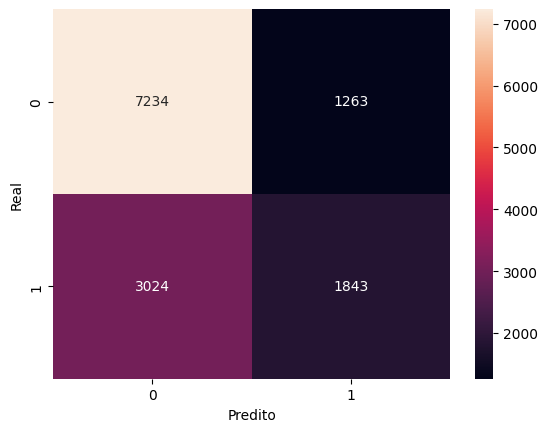

In [48]:
matriz_confusao(y_test, y_pred_xgb_baseline)

#### Árvore de Decisão e Floresta Aleatória

In [15]:
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

In [48]:
# param_grid_dt = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [3, 5, 7, 10],
#     'min_samples_split': [2, 5, 10]
# }

# param_grid_rf = {
#     'n_estimators': [10, 50, 100],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [3, 5, 7, 10],
#     'min_samples_split': [2, 5, 10]
# }

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'bootstrap': [True, False]
}

In [49]:
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=cv, n_jobs=-1, verbose=2)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=cv, n_jobs=-1, verbose=2)

In [ ]:
grid_search_dt.fit(X_train, y_train)

In [ ]:
grid_search_rf.fit(X_train, y_train)

In [53]:
y_pred_dt = grid_search_dt.best_estimator_.predict(X_test)
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)

In [54]:
print("Melhores parâmetros para Árvore de Decisão:", grid_search_dt.best_params_)
print("Relatório de Classificação para Árvore de Decisão:\n", classification_report(y_test, y_pred_dt))

Melhores parâmetros para Árvore de Decisão: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}
Relatório de Classificação para Árvore de Decisão:
               precision    recall  f1-score   support

         0.0       0.67      0.87      0.76      8497
         1.0       0.54      0.26      0.35      4867

    accuracy                           0.65     13364
   macro avg       0.61      0.57      0.56     13364
weighted avg       0.63      0.65      0.61     13364



Melhores parâmetros para Árvore de Decisão: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}

In [56]:
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Acurácia da Árvore de Decisão no conjunto de teste:", accuracy_dt)

precision_dt = precision_score(y_test, y_pred_dt)
print("Precisão da Árvore de Decisão no conjunto de teste:", precision_dt)

recall_dt = recall_score(y_test, y_pred_dt)
print("Recall da Árvore de Decisão no conjunto de teste:", recall_dt)

f1_dt = f1_score(y_test, y_pred_dt)
print("f1_score da Árvore de Decisão no conjunto de teste:", f1_dt)

Acurácia da Árvore de Decisão no conjunto de teste: 0.6502544148458546
Precisão da Árvore de Decisão no conjunto de teste: 0.541186513017499
Recall da Árvore de Decisão no conjunto de teste: 0.2605301006780357
f1_score da Árvore de Decisão no conjunto de teste: 0.35173370319001385


In [57]:
print("Melhores parâmetros para Random Forest:", grid_search_rf.best_params_)
print("Relatório de Classificação para Random Forest:\n", classification_report(y_test, y_pred_rf))

Melhores parâmetros para Random Forest: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 200}
Relatório de Classificação para Random Forest:
               precision    recall  f1-score   support

         0.0       0.69      0.89      0.78      8497
         1.0       0.60      0.29      0.39      4867

    accuracy                           0.67     13364
   macro avg       0.65      0.59      0.58     13364
weighted avg       0.66      0.67      0.64     13364



Melhores parâmetros para Random Forest: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 200}

In [59]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Acurácia Floresta Aleatória:", accuracy_rf)

precisao_rf = precision_score(y_test, y_pred_rf)
print("Precisão Floresta Aleatória:", precisao_rf)

recall_rf = recall_score(y_test, y_pred_rf)
print("Recall Floresta Aleatória:", recall_rf)

f1_rf = f1_score(y_test, y_pred_rf)
print("f1_score Floresta Aleatória:", f1_rf)

Acurácia Floresta Aleatória: 0.6725531278060461
Precisão Floresta Aleatória: 0.6046016190881977
Recall Floresta Aleatória: 0.29155537291966305
f1_score Floresta Aleatória: 0.3934017188799557


In [73]:
feature_names = X.columns
importances_dt = grid_search_dt.best_estimator_.feature_importances_ * 100
importances_rf = grid_search_rf.best_estimator_.feature_importances_ * 100
# for feature_name, importance in zip(feature_names, importances_rf):
#     print(f"{feature_name}: {importance}")

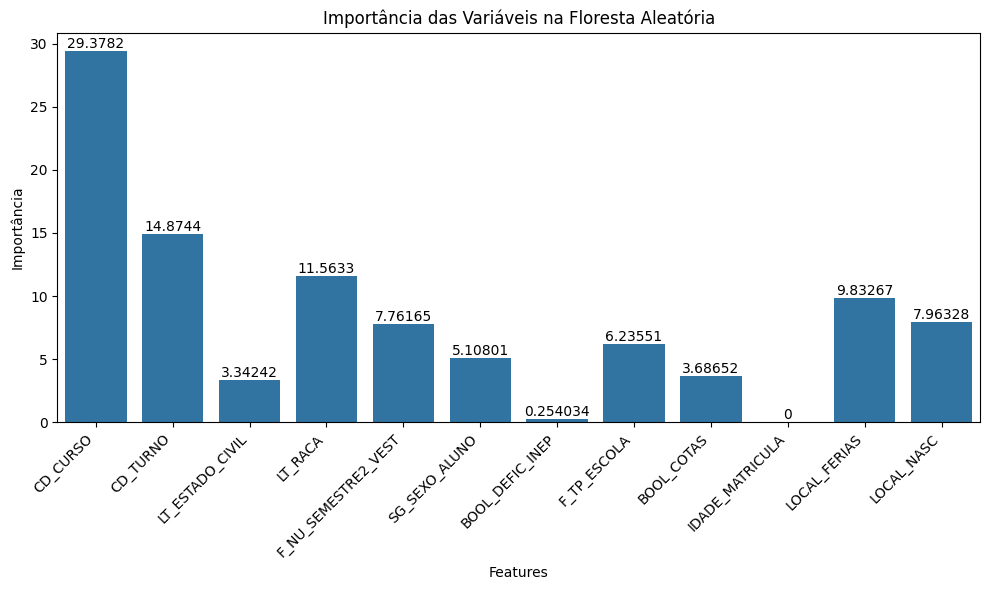

In [77]:
plt.figure(figsize=(10, 6))
vis = sns.barplot(x=feature_names, y=importances_dt)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na Floresta Aleatória")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

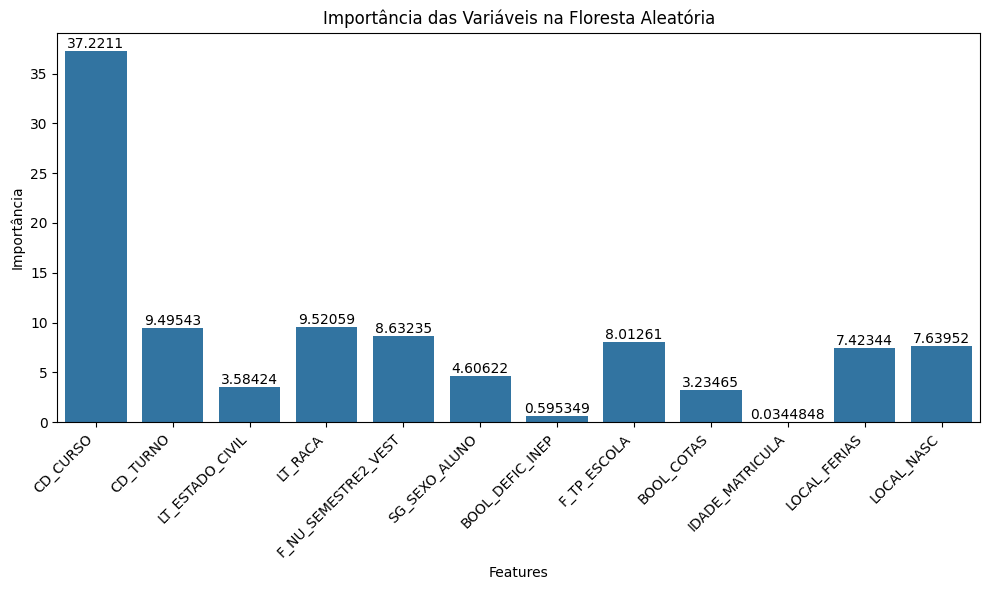

In [76]:
plt.figure(figsize=(10, 6))
vis = sns.barplot(x=feature_names, y=importances_rf)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na Floresta Aleatória")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### XGBoost

In [205]:
xgb = treinar_modelo('xgboost', X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [206]:
y_pred_xgb = get_predicoes(xgb, X_test)

In [207]:
get_parametros(xgb)

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 100,
 'subsample': 1.0}

In [208]:
avaliar_modelo(y_test, y_pred_xgb)

Acurácia : 0.679512122119126
Precisão : 0.5964332892998679
Recall : 0.3710704746250257
f1_score : 0.457504749841672


(0.679512122119126, 0.5964332892998679, 0.3710704746250257, 0.457504749841672)

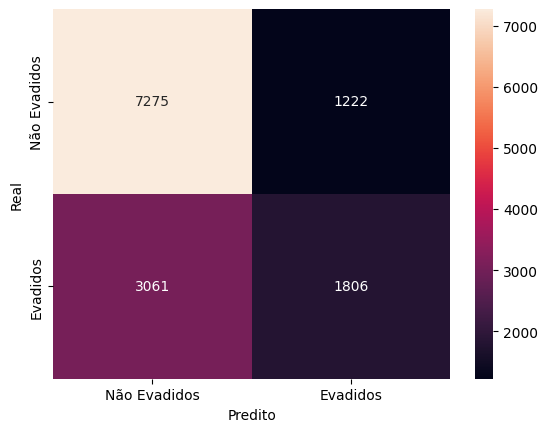

In [213]:
matriz_confusao(y_test, y_pred_xgb)

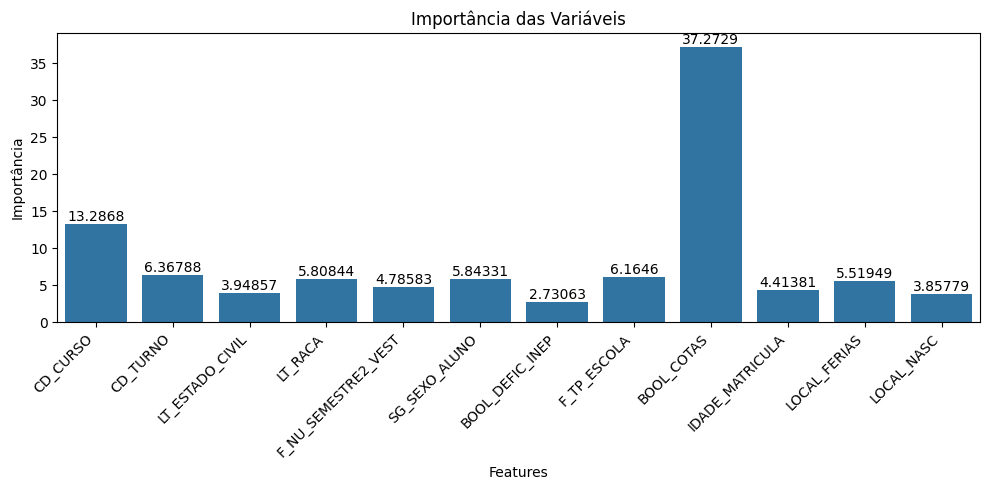

In [209]:
grafico_importancia_features(xgb, X)

In [211]:
get_report(y_test, y_pred_xgb)

              precision    recall  f1-score   support

         0.0       0.70      0.86      0.77      8497
         1.0       0.60      0.37      0.46      4867

    accuracy                           0.68     13364
   macro avg       0.65      0.61      0.62     13364
weighted avg       0.66      0.68      0.66     13364



### Modelo - Gerações completas apenas

In [214]:
df_geracoes_completas = df[df['GERACAO_COMPLETA'] == 1]
df_geracoes_completas.shape[0]

42249

In [215]:
X = df_geracoes_completas.drop(colunas_excluir_ml, axis=1)
y = df_geracoes_completas[target_bool]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [216]:
len(X_train), len(X_test), sum(y_train), sum(y_test)

(33799, 8450, 12110.0, 3028.0)

In [218]:
y_test.value_counts(), y_test.value_counts(normalize=True)

(BOOL_ST_ALUNO
 0.0    5422
 1.0    3028
 Name: count, dtype: int64,
 BOOL_ST_ALUNO
 0.0    0.641657
 1.0    0.358343
 Name: proportion, dtype: float64)

In [143]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [144]:
dt_gc = DecisionTreeClassifier(random_state=42)
rf_gc = RandomForestClassifier(random_state=42)
xgb_gc = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

In [162]:
param_grid_dt_gc = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_rf_gc = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_xgb_gc = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

In [149]:
grid_search_dt_gc = GridSearchCV(estimator=dt_gc, param_grid=param_grid_dt_gc, cv=cv, n_jobs=-1, verbose=2)
grid_search_rf_gc = GridSearchCV(estimator=rf_gc, param_grid=param_grid_rf_gc, cv=cv, n_jobs=-1, verbose=2)
grid_search_xgb_gc = GridSearchCV(estimator=xgb_gc, param_grid=param_grid_xgb_gc, cv=cv, n_jobs=-1, verbose=2)

#### Baseline

In [ ]:
dt_gc_baseline = DecisionTreeClassifier(random_state=42)
rf_gc_baseline = RandomForestClassifier(random_state=42)
xgb_gc_baseline = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

dt_gc_baseline.fit(X_train, y_train)
rf_gc_baseline.fit(X_train, y_train)
xgb_gc_baseline.fit(X_train, y_train)

y_pred_dt_gc_baseline = dt_gc_baseline.predict(X_test)
y_pred_rf_gc_baseline = rf_gc_baseline.predict(X_test)
y_pred_xgb_gc_baseline = xgb_gc_baseline.predict(X_test)

In [176]:
accuracy_dt_gc_baseline = accuracy_score(y_test, y_pred_dt_gc_baseline)
print("Acurácia Árvore de Decisão Gerações Completas Baseline:", accuracy_dt_gc_baseline)

precisao_dt_gc_baseline = precision_score(y_test, y_pred_dt_gc_baseline)
print("Precisão Árvore de Decisão Gerações Completas Baseline:", precisao_dt_gc_baseline)

recall_dt_gc_baseline = recall_score(y_test, y_pred_dt_gc_baseline)
print("Recall Árvore de Decisão Gerações Completas Baseline:", recall_dt_gc_baseline)

f1_dt_gc_baseline = f1_score(y_test, y_pred_dt_gc_baseline)
print("f1_score Árvore de Decisão Gerações Completas Baseline:", f1_dt_gc_baseline)

Acurácia Árvore de Decisão Gerações Completas Baseline: 0.641775147928994
Precisão Árvore de Decisão Gerações Completas Baseline: 0.5002114164904863
Recall Árvore de Decisão Gerações Completas Baseline: 0.39068692206076616
f1_score Árvore de Decisão Gerações Completas Baseline: 0.43871685518264414


In [177]:
accuracy_rf_gc_baseline = accuracy_score(y_test, y_pred_rf_gc_baseline)
print("Acurácia Floresta Aleatória Gerações Completas Baseline:", accuracy_rf_gc_baseline)

precisao_rf_gc_baseline = precision_score(y_test, y_pred_rf_gc_baseline)
print("Precisão Floresta Aleatória Gerações Completas Baseline:", precisao_rf_gc_baseline)

recall_rf_gc_baseline = recall_score(y_test, y_pred_rf_gc_baseline)
print("Recall Floresta Aleatória Gerações Completas Baseline:", recall_rf_gc_baseline)

f1_rf_gc_baseline = f1_score(y_test, y_pred_rf_gc_baseline)
print("f1_score Floresta Aleatória Gerações Completas Baseline:", f1_rf_gc_baseline)

Acurácia Floresta Aleatória Gerações Completas Baseline: 0.6539644970414201
Precisão Floresta Aleatória Gerações Completas Baseline: 0.5214521452145214
Recall Floresta Aleatória Gerações Completas Baseline: 0.41743725231175693
f1_score Floresta Aleatória Gerações Completas Baseline: 0.46368305209097577


In [178]:
accuracy_xgb_gc_baseline = accuracy_score(y_test, y_pred_xgb_gc_baseline)
print("Acurácia XGBoost Gerações Completas Baseline:", accuracy_xgb_gc_baseline)

precisao_xgb_gc_baseline = precision_score(y_test, y_pred_xgb_gc_baseline)
print("Precisão XGBoost Gerações Completas Baseline:", precisao_xgb_gc_baseline)

recall_xgb_gc_baseline = recall_score(y_test, y_pred_xgb_gc_baseline)
print("Recall XGBoost Gerações Completas Baseline:", recall_xgb_gc_baseline)

f1_xgb_gc_baseline = f1_score(y_test, y_pred_xgb_gc_baseline)
print("f1_score XGBoost Gerações Completas Baseline:", f1_xgb_gc_baseline)

Acurácia XGBoost Gerações Completas Baseline: 0.6959763313609467
Precisão XGBoost Gerações Completas Baseline: 0.6120058565153733
Recall XGBoost Gerações Completas Baseline: 0.4141347424042272
f1_score XGBoost Gerações Completas Baseline: 0.4939925152649203


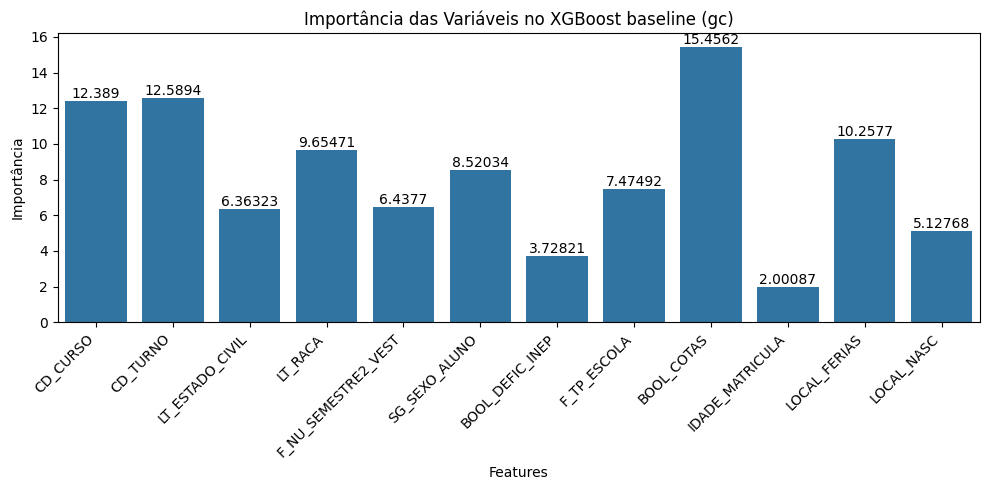

In [179]:
feature_names = X.columns
importances_xgb_gc_baseline = xgb_gc_baseline.feature_importances_ * 100

plt.figure(figsize=(10, 5))
vis = sns.barplot(x=feature_names, y=importances_xgb_gc_baseline)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis no XGBoost baseline (gc)")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Árvore

In [154]:
grid_search_dt_gc.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             verbose=2)

In [155]:
y_pred_dt_gc = grid_search_dt_gc.best_estimator_.predict(X_test)

In [156]:
print("Melhores parâmetros para Árvore de Decisão:", grid_search_dt_gc.best_params_)
print("Relatório de Classificação para Árvore de Decisão:\n", classification_report(y_test, y_pred_dt_gc))

Melhores parâmetros para Árvore de Decisão: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Relatório de Classificação para Árvore de Decisão:
               precision    recall  f1-score   support

         0.0       0.70      0.87      0.77      5422
         1.0       0.58      0.33      0.42      3028

    accuracy                           0.67      8450
   macro avg       0.64      0.60      0.60      8450
weighted avg       0.66      0.67      0.65      8450



In [157]:
accuracy_dt = accuracy_score(y_test, y_pred_dt_gc)
print("Acurácia da Árvore de Decisão (gc):", accuracy_dt)

precision_dt = precision_score(y_test, y_pred_dt_gc)
print("Precisão da Árvore de Decisão (gc):", precision_dt)

recall_dt = recall_score(y_test, y_pred_dt_gc)
print("Recall da Árvore de Decisão (gc):", recall_dt)

f1_dt = f1_score(y_test, y_pred_dt_gc)
print("f1_score da Árvore de Decisão (gc):", f1_dt)

Acurácia da Árvore de Decisão (gc): 0.6744378698224852
Precisão da Árvore de Decisão (gc): 0.5801968731905037
Recall da Árvore de Decisão (gc): 0.33091149273447823
f1_score da Árvore de Decisão (gc): 0.42145110410094644


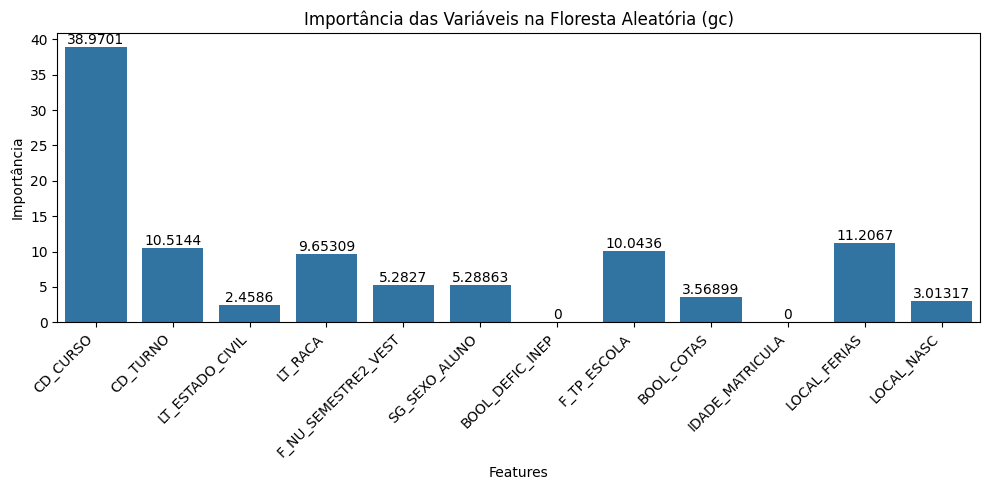

In [167]:
feature_names = X.columns
importances_dt_gc = grid_search_dt_gc.best_estimator_.feature_importances_ * 100

plt.figure(figsize=(10, 5))
vis = sns.barplot(x=feature_names, y=importances_dt_gc)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na Floresta Aleatória (gc)")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Floresta

In [169]:
grid_search_rf_gc.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [170]:
y_pred_rf_gc = grid_search_rf_gc.best_estimator_.predict(X_test)

In [171]:
print("Melhores parâmetros para Floresta (gc):", grid_search_rf_gc.best_params_)
print("Relatório de Classificação para Floresta (gc):\n", classification_report(y_test, y_pred_rf_gc))

Melhores parâmetros para Floresta (gc): {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 200}
Relatório de Classificação para Floresta (gc):
               precision    recall  f1-score   support

         0.0       0.70      0.89      0.78      5422
         1.0       0.62      0.32      0.43      3028

    accuracy                           0.69      8450
   macro avg       0.66      0.61      0.61      8450
weighted avg       0.67      0.69      0.66      8450



In [172]:
accuracy_rf = accuracy_score(y_test, y_pred_rf_gc)
print("Acurácia da XGB (gc):", accuracy_rf)

precision_rf = precision_score(y_test, y_pred_rf_gc)
print("Precisão da XGB (gc):", precision_rf)

recall_rf = recall_score(y_test, y_pred_rf_gc)
print("Recall da XGB (gc):", recall_rf)

f1_rf = f1_score(y_test, y_pred_rf_gc)
print("f1_score da XGB (gc):", f1_rf)

Acurácia da XGB (gc): 0.6871005917159764
Precisão da XGB (gc): 0.6212121212121212
Recall da XGB (gc): 0.3249669749009247
f1_score da XGB (gc): 0.42671292281006074


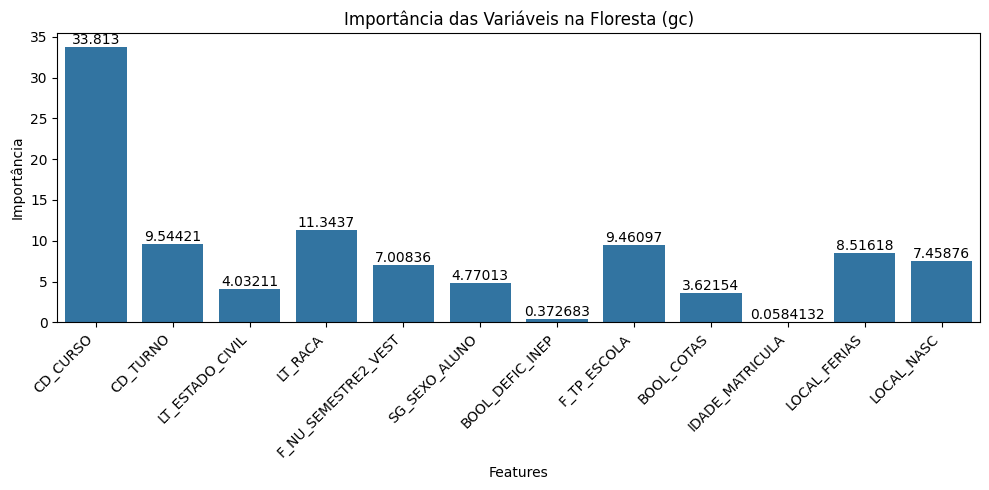

In [173]:
feature_names = X.columns
importances_rf_gc = grid_search_rf_gc.best_estimator_.feature_importances_ * 100

plt.figure(figsize=(10, 5))
vis = sns.barplot(x=feature_names, y=importances_rf_gc)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na Floresta (gc)")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### XGBoost

In [163]:
grid_search_xgb_gc.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [10, 20, 30],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 0.8, 1.0]},
             verbose=2)

In [164]:
y_pred_xgb_gc = grid_search_xgb_gc.best_estimator_.predict(X_test)

In [165]:
print("Melhores parâmetros para XGB:", grid_search_xgb_gc.best_params_)
print("Relatório de Classificação para XGB:\n", classification_report(y_test, y_pred_xgb_gc))

Melhores parâmetros para XGB: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.8}
Relatório de Classificação para XGB:
               precision    recall  f1-score   support

         0.0       0.71      0.88      0.79      5422
         1.0       0.63      0.36      0.46      3028

    accuracy                           0.69      8450
   macro avg       0.67      0.62      0.62      8450
weighted avg       0.68      0.69      0.67      8450



In [166]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb_gc)
print("Acurácia da XGB (gc):", accuracy_xgb)

precision_xgb = precision_score(y_test, y_pred_xgb_gc)
print("Precisão da XGB (gc):", precision_xgb)

recall_xgb = recall_score(y_test, y_pred_xgb_gc)
print("Recall da XGB (gc):", recall_xgb)

f1_xgb = f1_score(y_test, y_pred_xgb_gc)
print("f1_score da XGB (gc):", f1_xgb)

Acurácia da XGB (gc): 0.6946745562130178
Precisão da XGB (gc): 0.6278538812785388
Recall da XGB (gc): 0.3632760898282695
f1_score da XGB (gc): 0.46025104602510464


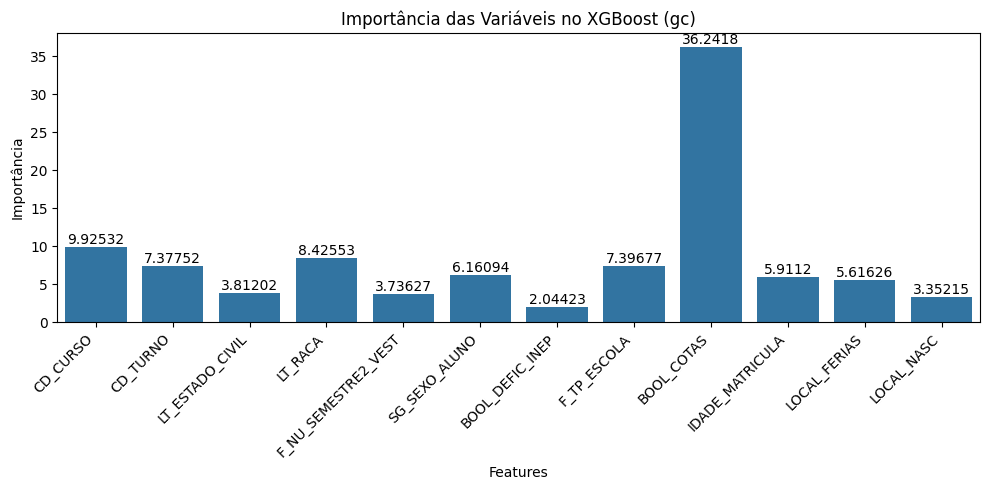

In [168]:
feature_names = X.columns
importances_xgb_gc = grid_search_xgb_gc.best_estimator_.feature_importances_ * 100

plt.figure(figsize=(10, 5))
vis = sns.barplot(x=feature_names, y=importances_xgb_gc)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis no XGBoost (gc)")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Modelo para gerações antigas no treino e gerações mais novas no teste

In [223]:
df_geracoes_completas['NUMERO_GERACAO'].nunique()

16

In [224]:
df_geracoes_completas = df[df['GERACAO_COMPLETA'] == 1]
df_geracoes_completas.shape[0]

42249

In [225]:
X_train = df_geracoes_completas[df_geracoes_completas['NUMERO_GERACAO'] <= 10].drop(colunas_excluir_ml, axis=1)
y_train = df_geracoes_completas[df_geracoes_completas['NUMERO_GERACAO'] <= 10][target_bool]

X_test = df_geracoes_completas[df_geracoes_completas['NUMERO_GERACAO'] > 10].drop(colunas_excluir_ml, axis=1)
y_test = df_geracoes_completas[df_geracoes_completas['NUMERO_GERACAO'] > 10][target_bool]

len(X_train), len(X_test), sum(y_train), sum(y_test)

(31946, 10303, 10671.0, 4467.0)

In [226]:
y_train.value_counts(), y_train.value_counts(normalize=True),

(BOOL_ST_ALUNO
 0.0    21275
 1.0    10671
 Name: count, dtype: int64,
 BOOL_ST_ALUNO
 0.0    0.665968
 1.0    0.334032
 Name: proportion, dtype: float64)

In [227]:
y_test.value_counts(), y_test.value_counts(normalize=True),

(BOOL_ST_ALUNO
 0.0    5836
 1.0    4467
 Name: count, dtype: int64,
 BOOL_ST_ALUNO
 0.0    0.566437
 1.0    0.433563
 Name: proportion, dtype: float64)

In [222]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt_ga = DecisionTreeClassifier(random_state=42)
rf_ga = RandomForestClassifier(random_state=42)
xgb_ga = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

param_grid_dt_ga = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_rf_ga = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_xgb_ga = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

grid_search_dt_ga = GridSearchCV(estimator=dt_ga, param_grid=param_grid_dt_ga, cv=cv, n_jobs=-1, verbose=2)
grid_search_rf_ga = GridSearchCV(estimator=rf_ga, param_grid=param_grid_rf_ga, cv=cv, n_jobs=-1, verbose=2)
grid_search_xgb_ga = GridSearchCV(estimator=xgb_ga, param_grid=param_grid_xgb_ga, cv=cv, n_jobs=-1, verbose=2)

AttributeError: 'GridSearchCV' object has no attribute 'XGBClassifier'

#### Baseline

In [30]:
y_pred_ga = np.zeros(len(y_test))

avaliar_modelo(y_test, y_pred_ga)

Acurácia : 0.5664369601087063
Precisão : 0.0
Recall : 0.0
f1_score : 0.0


c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5664369601087063, 0.0, 0.0, 0.0)

#### Árvore

In [31]:
grid_search_dt_ga.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             verbose=2)

In [32]:
y_pred_dt_ga = grid_search_dt_ga.best_estimator_.predict(X_test)

In [33]:
print("Melhores parâmetros para Árvore de Decisão:", grid_search_dt_ga.best_params_)
print("Relatório de Classificação para Árvore de Decisão:\n", classification_report(y_test, y_pred_dt_ga))

Melhores parâmetros para Árvore de Decisão: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Relatório de Classificação para Árvore de Decisão:
               precision    recall  f1-score   support

         0.0       0.59      0.93      0.72      5836
         1.0       0.64      0.15      0.25      4467

    accuracy                           0.60     10303
   macro avg       0.61      0.54      0.49     10303
weighted avg       0.61      0.60      0.52     10303



In [34]:
avaliar_modelo(y_test, y_pred_dt_ga)

Acurácia : 0.5954576336989227
Precisão : 0.6393289841565704
Recall : 0.15357062905753302
f1_score : 0.24765342960288805


(0.5954576336989227,
 0.6393289841565704,
 0.15357062905753302,
 0.24765342960288805)

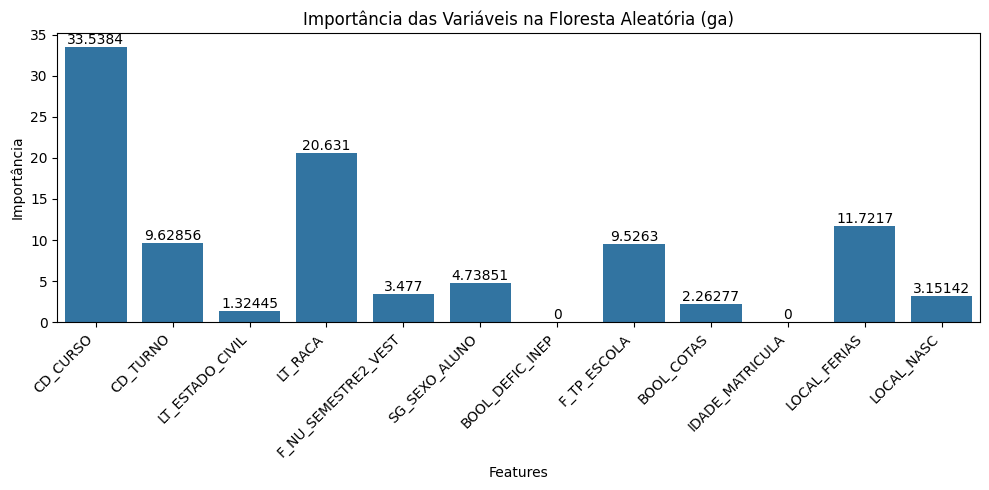

In [35]:
feature_names = X.columns
importances_dt_ga = grid_search_dt_ga.best_estimator_.feature_importances_ * 100

plt.figure(figsize=(10, 5))
vis = sns.barplot(x=feature_names, y=importances_dt_ga)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na Floresta Aleatória (ga)")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Floresta

In [36]:
grid_search_rf_ga.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [37]:
y_pred_rf_ga = grid_search_rf_ga.best_estimator_.predict(X_test)

In [39]:
print("Melhores parâmetros para Floresta (ga):", grid_search_rf_ga.best_params_)
print("Relatório de Classificação para Floresta (ga):\n", classification_report(y_test, y_pred_rf_ga))

Melhores parâmetros para Floresta (ga): {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
Relatório de Classificação para Floresta (ga):
               precision    recall  f1-score   support

         0.0       0.58      0.98      0.73      5836
         1.0       0.74      0.06      0.12      4467

    accuracy                           0.58     10303
   macro avg       0.66      0.52      0.42     10303
weighted avg       0.65      0.58      0.46     10303



In [38]:
avaliar_modelo(y_test, y_pred_rf_ga)

Acurácia : 0.584295836164224
Precisão : 0.7383419689119171
Recall : 0.06380120886501008
f1_score : 0.11745312178034206


(0.584295836164224,
 0.7383419689119171,
 0.06380120886501008,
 0.11745312178034206)

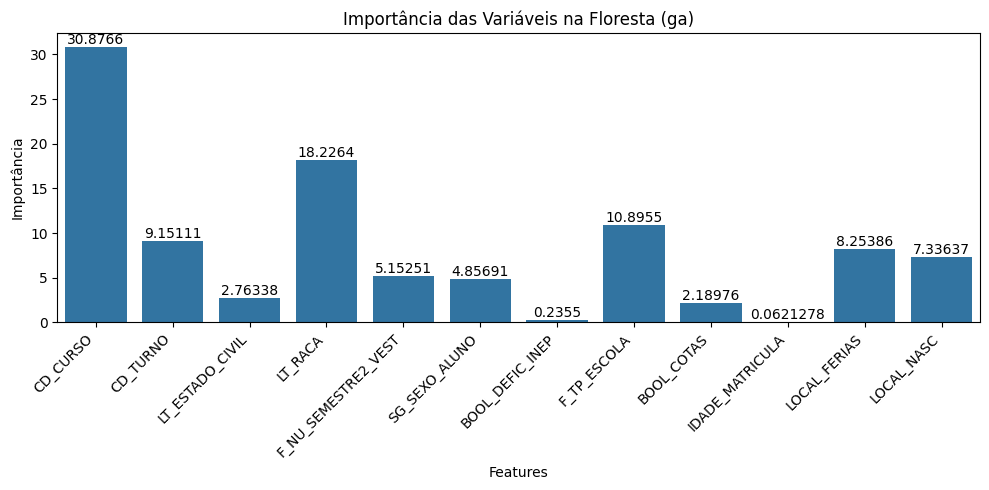

In [40]:
feature_names = X.columns
importances_rf_ga = grid_search_rf_ga.best_estimator_.feature_importances_ * 100

plt.figure(figsize=(10, 5))
vis = sns.barplot(x=feature_names, y=importances_rf_ga)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na Floresta (ga)")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### XGBoost

In [41]:
grid_search_xgb_ga.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [10, 20, 30],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 0.8, 1.0]},
             verbose=2)

In [42]:
y_pred_xgb_ga = grid_search_xgb_ga.best_estimator_.predict(X_test)

In [43]:
print("Melhores parâmetros para XGB:", grid_search_xgb_ga.best_params_)
print("Relatório de Classificação para XGB:\n", classification_report(y_test, y_pred_xgb_ga))

Melhores parâmetros para XGB: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.5}
Relatório de Classificação para XGB:
               precision    recall  f1-score   support

         0.0       0.59      0.97      0.73      5836
         1.0       0.72      0.12      0.20      4467

    accuracy                           0.60     10303
   macro avg       0.65      0.54      0.47     10303
weighted avg       0.65      0.60      0.50     10303



In [44]:
avaliar_modelo(y_test, y_pred_xgb_ga)

Acurácia : 0.5977870523148597
Precisão : 0.7209302325581395
Recall : 0.11797627042758004
f1_score : 0.2027702962677953


(0.5977870523148597,
 0.7209302325581395,
 0.11797627042758004,
 0.2027702962677953)

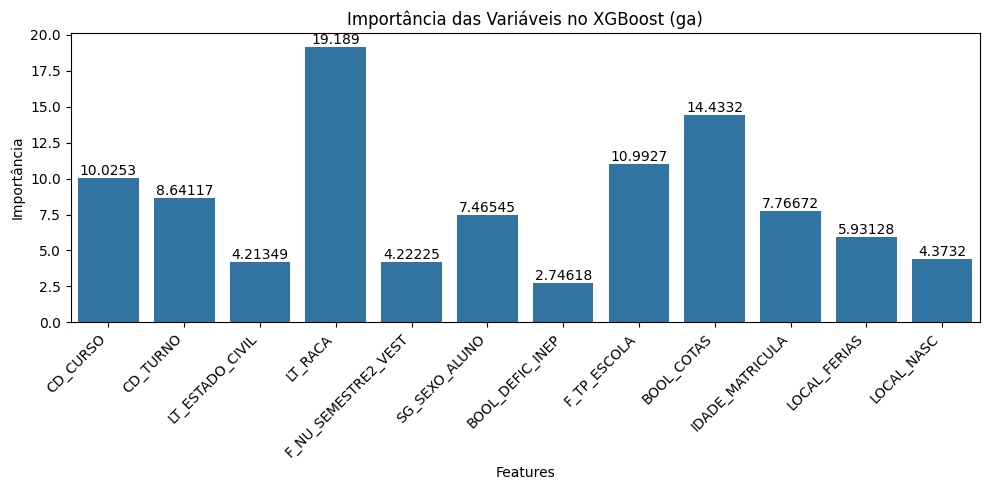

In [45]:
feature_names = X.columns
importances_xgb_ga = grid_search_xgb_ga.best_estimator_.feature_importances_ * 100

plt.figure(figsize=(10, 5))
vis = sns.barplot(x=feature_names, y=importances_xgb_ga)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis no XGBoost (ga)")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Modelo para um Centro

#### CTC

In [242]:
df_ctc = df[df['SG_CENTRO'] == 'CTC']

X = df_ctc.drop(colunas_excluir_ml, axis=1)
y = df_ctc[target_bool]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

len(X_train), len(X_test), sum(y_train), sum(y_test)

(12650, 3163, 4741.0, 1186.0)

In [243]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(BOOL_ST_ALUNO
 0.0    0.625217
 1.0    0.374783
 Name: proportion, dtype: float64,
 BOOL_ST_ALUNO
 0.0    0.62504
 1.0    0.37496
 Name: proportion, dtype: float64)

##### Baseline

In [29]:
y_pred_ctc = np.zeros(len(y_test))

avaliar_modelo(y_test, y_pred_ctc)

Acurácia : 0.6250395194435663
Precisão : 0.0
Recall : 0.0
f1_score : 0.0


c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.6250395194435663, 0.0, 0.0, 0.0)

##### Árvore

In [30]:
arvore_ctc = treinar_modelo('arvore', X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [31]:
predicoes_arvore_ctc = get_predicoes(arvore_ctc, X_test)

In [32]:
get_parametros(arvore_ctc)

{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}

In [33]:
avaliar_modelo(y_test, predicoes_arvore_ctc)

Acurácia : 0.6452734745494784
Precisão : 0.5473372781065089
Recall : 0.31197301854974707
f1_score : 0.39742212674543503


(0.6452734745494784,
 0.5473372781065089,
 0.31197301854974707,
 0.39742212674543503)

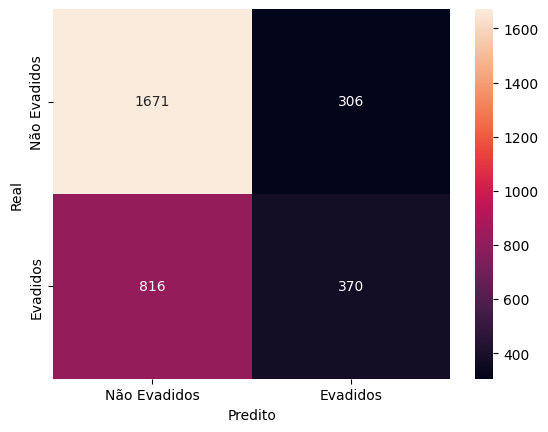

In [244]:
matriz_confusao(y_test, predicoes_arvore_ctc)

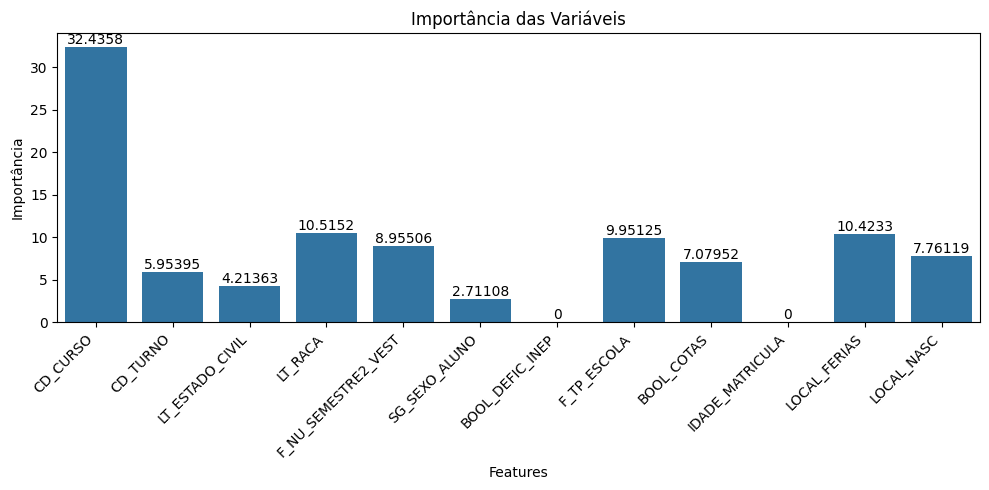

In [35]:
grafico_importancia_features(arvore_ctc, X)

In [38]:
get_report(y_test, predicoes_arvore_ctc)

              precision    recall  f1-score   support

         0.0       0.67      0.85      0.75      1977
         1.0       0.55      0.31      0.40      1186

    accuracy                           0.65      3163
   macro avg       0.61      0.58      0.57      3163
weighted avg       0.63      0.65      0.62      3163



##### Floresta

In [39]:
floresta_ctc = treinar_modelo('floresta', X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [40]:
predicoes_floresta_ctc = get_predicoes(floresta_ctc, X_test)

In [41]:
get_parametros(floresta_ctc)

{'max_depth': 30,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'n_estimators': 100}

In [42]:
avaliar_modelo(y_test, predicoes_floresta_ctc)

Acurácia : 0.6588681631362631
Precisão : 0.5799701046337817
Recall : 0.327150084317032
f1_score : 0.4183288409703504


(0.6588681631362631, 0.5799701046337817, 0.327150084317032, 0.4183288409703504)

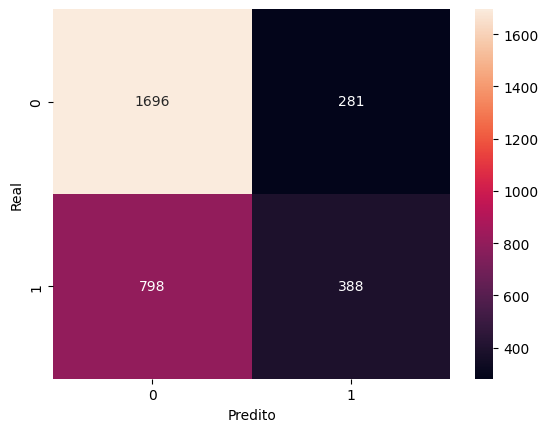

In [43]:
matriz_confusao(y_test, predicoes_floresta_ctc)

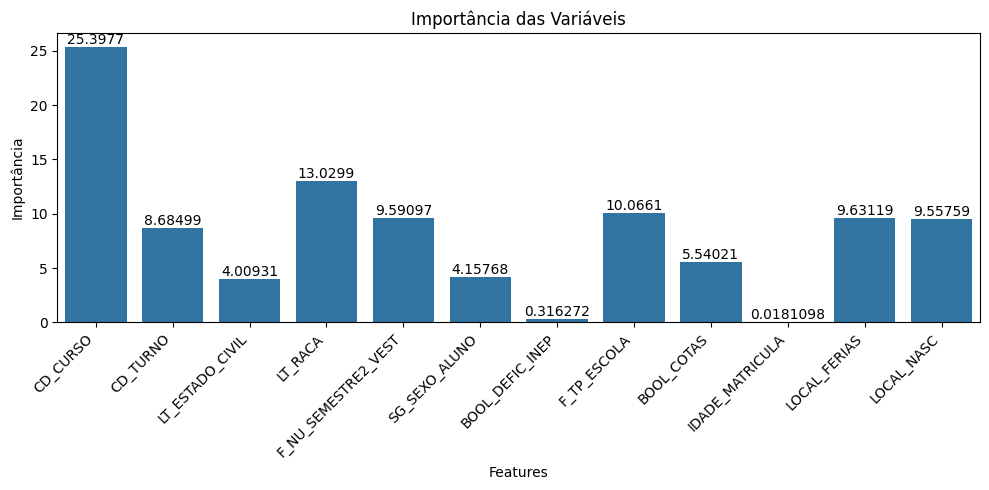

In [44]:
grafico_importancia_features(floresta_ctc, X)

In [49]:
get_report(y_test, predicoes_floresta_ctc)

              precision    recall  f1-score   support

         0.0       0.68      0.86      0.76      1977
         1.0       0.58      0.33      0.42      1186

    accuracy                           0.66      3163
   macro avg       0.63      0.59      0.59      3163
weighted avg       0.64      0.66      0.63      3163



##### XGBoost

In [45]:
xgboost_ctc = treinar_modelo('xgboost', X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [246]:
predicoes_xgboost_ctc = get_predicoes(xgboost_ctc, X_test)

In [47]:
get_parametros(xgboost_ctc)

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 20,
 'n_estimators': 200,
 'subsample': 1.0}

In [48]:
avaliar_modelo(y_test, predicoes_xgboost_ctc)

Acurácia : 0.6595004742333228
Precisão : 0.6345679012345679
Recall : 0.2166947723440135
f1_score : 0.32306725329981145


(0.6595004742333228,
 0.6345679012345679,
 0.2166947723440135,
 0.32306725329981145)

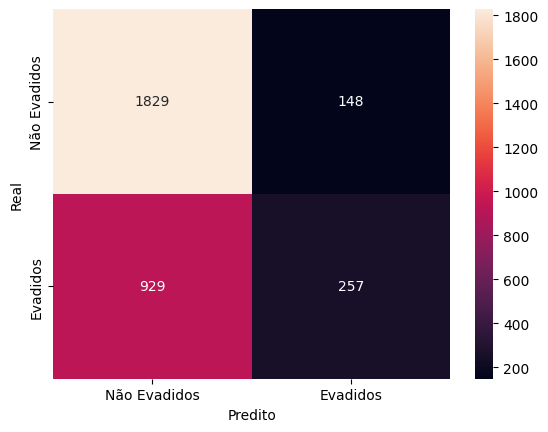

In [247]:
matriz_confusao(y_test, predicoes_xgboost_ctc)

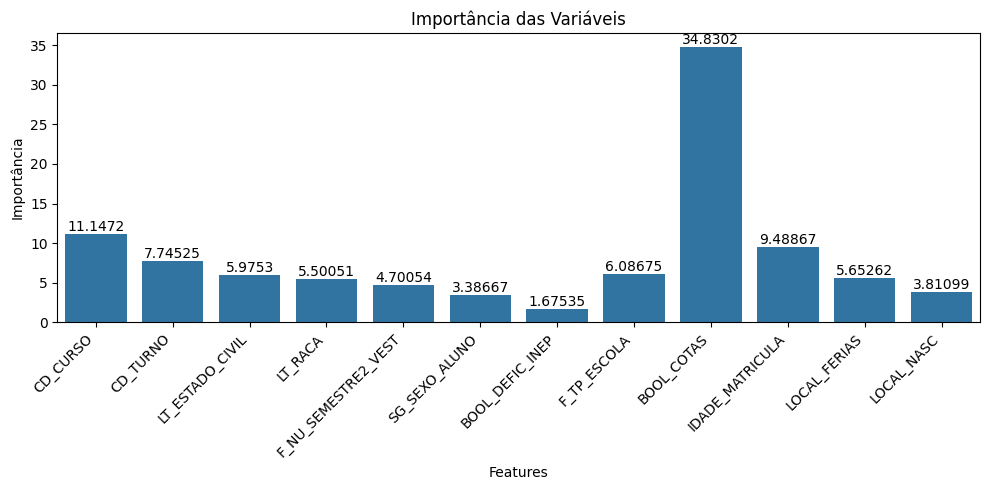

In [51]:
grafico_importancia_features(xgboost_ctc, X)

In [52]:
get_report(y_test, predicoes_xgboost_ctc)

              precision    recall  f1-score   support

         0.0       0.66      0.93      0.77      1977
         1.0       0.63      0.22      0.32      1186

    accuracy                           0.66      3163
   macro avg       0.65      0.57      0.55      3163
weighted avg       0.65      0.66      0.60      3163



#### CCE

In [235]:
df_cce = df[df['SG_CENTRO'] == 'CCE']

X = df_cce.drop(colunas_excluir_ml, axis=1)
y = df_cce[target_bool]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

len(X_train), len(X_test), sum(y_train), sum(y_test)

(4983, 1246, 2977.0, 744.0)

In [236]:
df_cce.shape[0]

6229

In [237]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(BOOL_ST_ALUNO
 1.0    0.597431
 0.0    0.402569
 Name: proportion, dtype: float64,
 BOOL_ST_ALUNO
 1.0    0.597111
 0.0    0.402889
 Name: proportion, dtype: float64)

##### Baseline

In [55]:
get_baseline(y_test)

Acurácia : 0.4028892455858748
Precisão : 0.0
Recall : 0.0
f1_score : 0.0


c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4028892455858748, 0.0, 0.0, 0.0)

##### Árvore

In [56]:
arvore_cce = treinar_modelo('arvore', X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [57]:
predicoes_arvore_cce = get_predicoes(arvore_cce, X_test)

In [58]:
get_parametros(arvore_cce)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [59]:
avaliar_modelo(y_test, predicoes_arvore_cce)

Acurácia : 0.6059390048154093
Precisão : 0.6486486486486487
Recall : 0.7419354838709677
f1_score : 0.6921630094043888


(0.6059390048154093,
 0.6486486486486487,
 0.7419354838709677,
 0.6921630094043888)

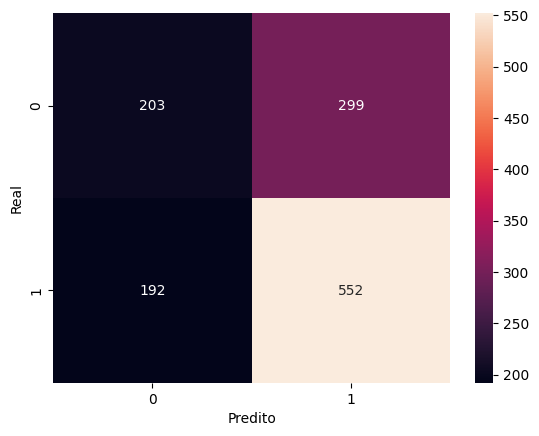

In [60]:
matriz_confusao(y_test, predicoes_arvore_cce)

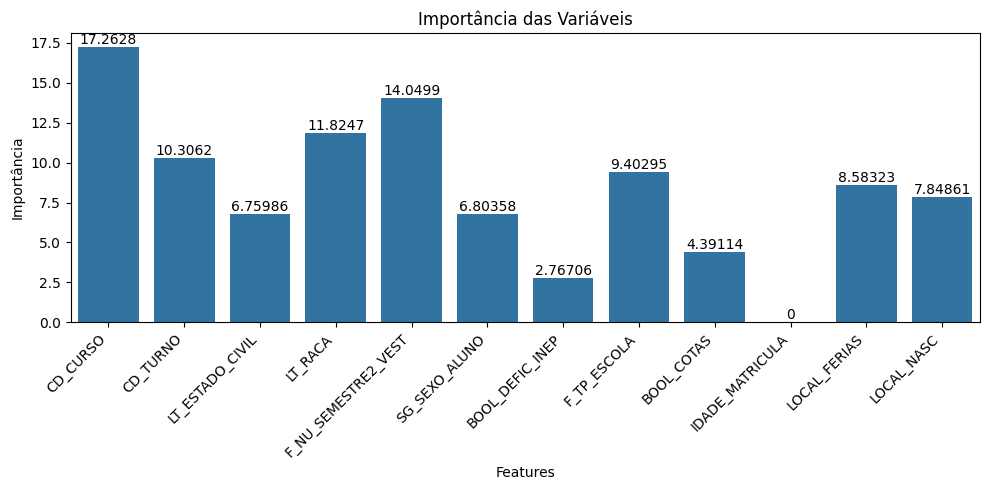

In [61]:
grafico_importancia_features(arvore_cce, X)

In [62]:
get_report(y_test, predicoes_arvore_cce)

              precision    recall  f1-score   support

         0.0       0.51      0.40      0.45       502
         1.0       0.65      0.74      0.69       744

    accuracy                           0.61      1246
   macro avg       0.58      0.57      0.57      1246
weighted avg       0.59      0.61      0.60      1246



##### Floresta

In [63]:
floresta_cce = treinar_modelo('floresta', X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [64]:
predicoes_floresta_cce = get_predicoes(floresta_cce, X_test)

In [65]:
get_parametros(floresta_cce)

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'n_estimators': 50}

In [66]:
avaliar_modelo(y_test, predicoes_floresta_cce)

Acurácia : 0.6211878009630819
Precisão : 0.6335952848722987
Recall : 0.8669354838709677
f1_score : 0.7321225879682179


(0.6211878009630819,
 0.6335952848722987,
 0.8669354838709677,
 0.7321225879682179)

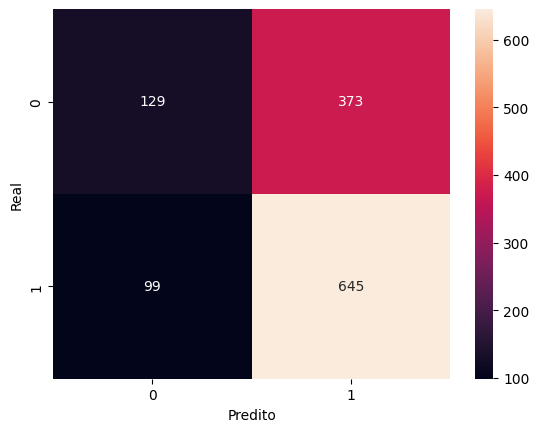

In [67]:
matriz_confusao(y_test, predicoes_floresta_cce)

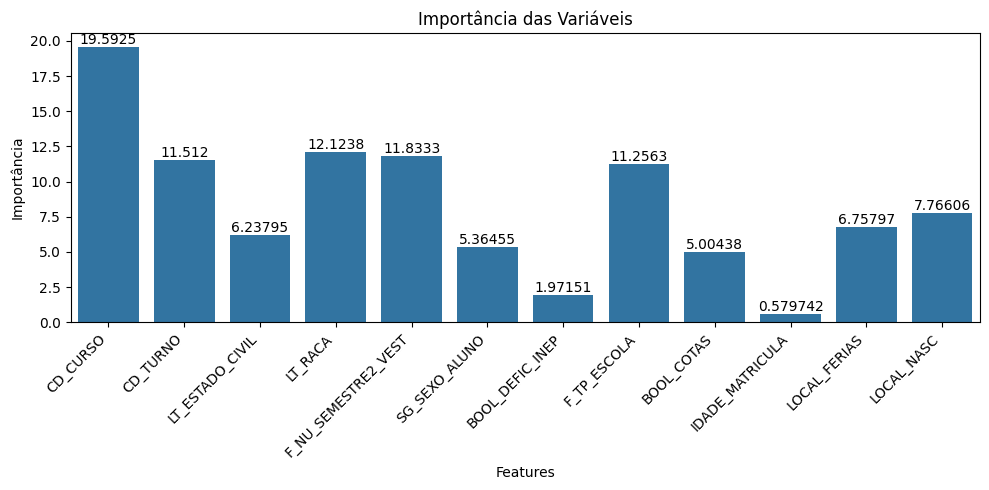

In [68]:
grafico_importancia_features(floresta_cce, X)

In [69]:
get_report(y_test, predicoes_floresta_cce)

              precision    recall  f1-score   support

         0.0       0.57      0.26      0.35       502
         1.0       0.63      0.87      0.73       744

    accuracy                           0.62      1246
   macro avg       0.60      0.56      0.54      1246
weighted avg       0.61      0.62      0.58      1246



##### XGBoost

In [70]:
xgboost_cce = treinar_modelo('xgboost', X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [238]:
predicoes_xgboost_cce = get_predicoes(xgboost_cce, X_test)

In [239]:
get_parametros(xgboost_cce)

{'colsample_bytree': 1.0,
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 200,
 'subsample': 0.5}

In [240]:
avaliar_modelo(y_test, predicoes_xgboost_cce)

Acurácia : 0.6171749598715891
Precisão : 0.6386292834890965
Recall : 0.8266129032258065
f1_score : 0.7205623901581723


(0.6171749598715891,
 0.6386292834890965,
 0.8266129032258065,
 0.7205623901581723)

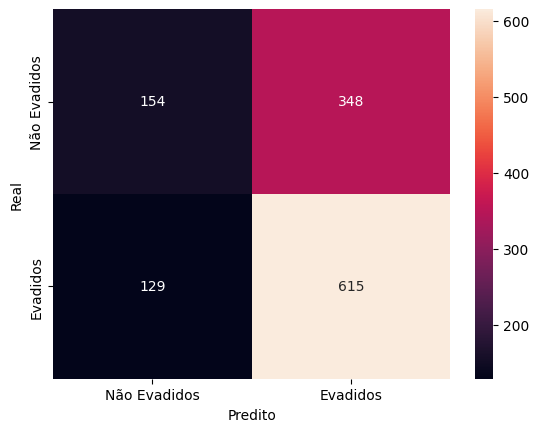

In [241]:
matriz_confusao(y_test, predicoes_xgboost_cce)

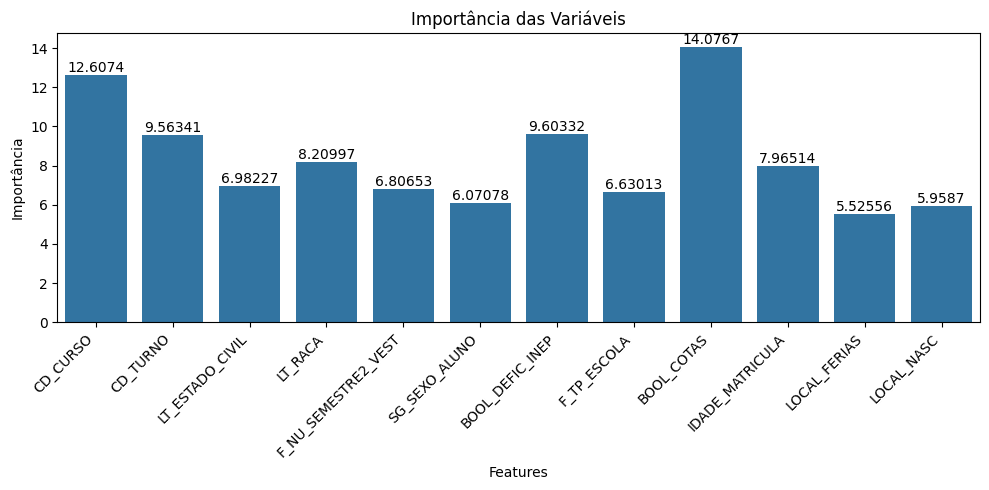

In [76]:
grafico_importancia_features(xgboost_cce, X)

In [233]:
get_report(y_test, predicoes_xgboost_cce)

              precision    recall  f1-score   support

         0.0       0.67      0.12      0.20      1977
         1.0       0.38      0.90      0.54      1186

    accuracy                           0.41      3163
   macro avg       0.53      0.51      0.37      3163
weighted avg       0.56      0.41      0.33      3163



### Modelo para um único curso

#### Computação

In [329]:
df[['CD_CURSO', 'NM_CURSO']].value_counts().sort_index()

CD_CURSO  NM_CURSO                            
0         Ciências Econômicas                     2659
1         Direito                                 3682
2         Letras                                  3318
3         Geografia                               2077
4         História                                1785
5         Química                                 1901
6         Matemática                              1905
7         Administração                           3490
8         Engenharia Civil                        1883
9         Engenharia Química                      2059
10        Educação Física                         2972
11        Ciências Contábeis                      2551
12        Pedagogia                               2626
13        Ciências Biológicas                     1962
14        Física                                  1326
15        Farmácia                                1617
16        Zootecnia                               1739
17        Agronomi

In [297]:
df_comp = df[df['CD_CURSO'] == 23]

X = df_comp.drop(colunas_excluir_ml, axis=1)
y = df_comp[target_bool]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

len(X_train), len(X_test), sum(y_train), sum(y_test)

(788, 197, 339.0, 85.0)

In [300]:
df_comp['BOOL_ST_ALUNO'].value_counts()

BOOL_ST_ALUNO
0.0    561
1.0    424
Name: count, dtype: int64

In [301]:
df_comp.shape[0]

985

In [302]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(BOOL_ST_ALUNO
 0.0    0.569797
 1.0    0.430203
 Name: proportion, dtype: float64,
 BOOL_ST_ALUNO
 0.0    0.568528
 1.0    0.431472
 Name: proportion, dtype: float64)

##### Baseline

In [303]:
get_baseline(y_test)

Acurácia : 0.5685279187817259
Precisão : 0.0
Recall : 0.0
f1_score : 0.0


c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5685279187817259, 0.0, 0.0, 0.0)

##### Árvore

In [304]:
arvore_computacao = treinar_modelo('arvore', X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [305]:
predicoes_arvore_computacao = get_predicoes(arvore_computacao, X_test)

In [306]:
get_parametros(arvore_computacao)

{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}

In [307]:
avaliar_modelo(y_test, predicoes_arvore_computacao)

Acurácia : 0.6446700507614214
Precisão : 0.631578947368421
Recall : 0.4235294117647059
f1_score : 0.5070422535211268


(0.6446700507614214, 0.631578947368421, 0.4235294117647059, 0.5070422535211268)

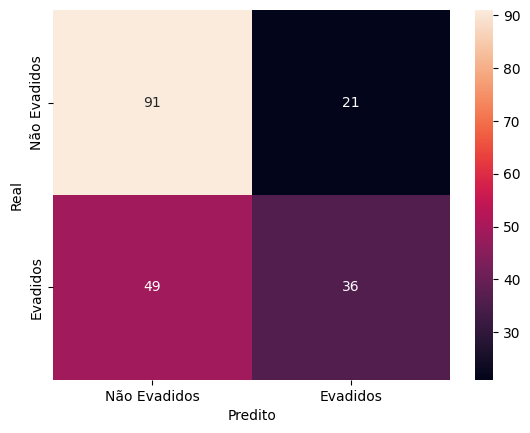

In [308]:
matriz_confusao(y_test, predicoes_arvore_computacao)

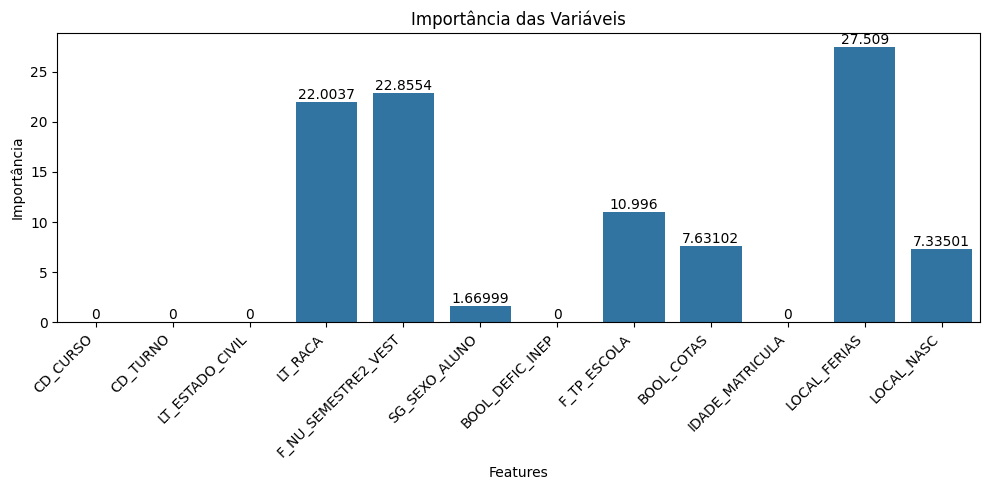

In [309]:
grafico_importancia_features(arvore_computacao, X)

In [310]:
get_report(y_test, predicoes_arvore_computacao)

              precision    recall  f1-score   support

         0.0       0.65      0.81      0.72       112
         1.0       0.63      0.42      0.51        85

    accuracy                           0.64       197
   macro avg       0.64      0.62      0.61       197
weighted avg       0.64      0.64      0.63       197



##### Floresta

In [311]:
floresta_computacao = treinar_modelo('floresta', X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [312]:
predicoes_floresta_computacao = get_predicoes(floresta_computacao, X_test)

In [313]:
get_parametros(floresta_computacao)

{'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'n_estimators': 50}

In [314]:
avaliar_modelo(y_test, predicoes_floresta_computacao)

Acurácia : 0.6243654822335025
Precisão : 0.6078431372549019
Recall : 0.36470588235294116
f1_score : 0.45588235294117646


(0.6243654822335025,
 0.6078431372549019,
 0.36470588235294116,
 0.45588235294117646)

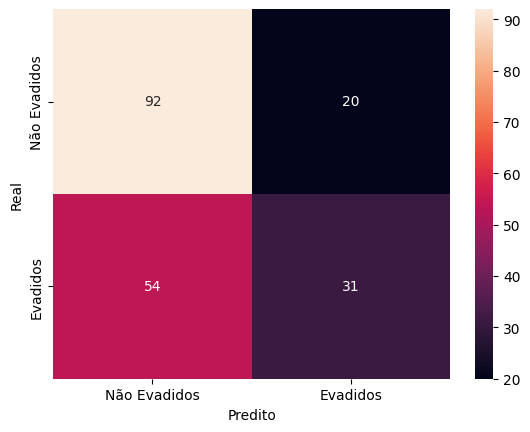

In [315]:
matriz_confusao(y_test, predicoes_floresta_computacao)

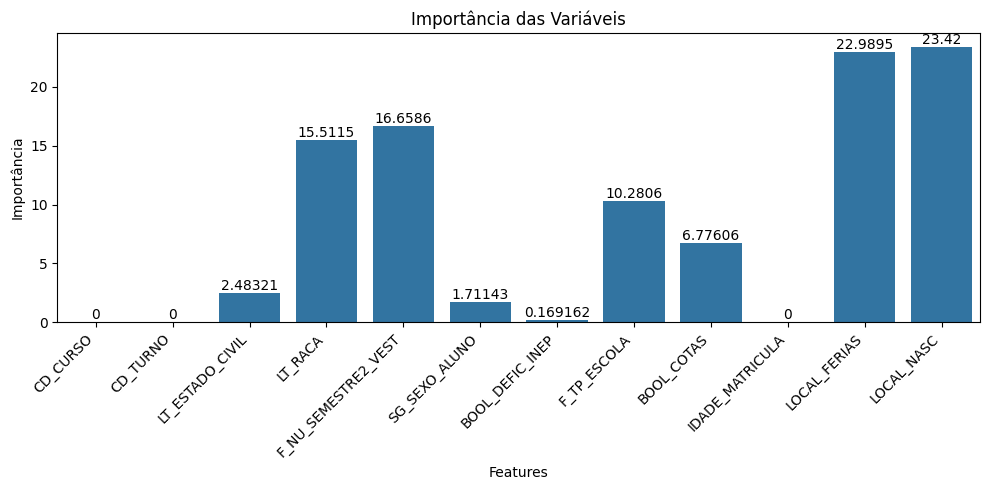

In [316]:
grafico_importancia_features(floresta_computacao, X)

In [317]:
get_report(y_test, predicoes_floresta_computacao)

              precision    recall  f1-score   support

         0.0       0.63      0.82      0.71       112
         1.0       0.61      0.36      0.46        85

    accuracy                           0.62       197
   macro avg       0.62      0.59      0.58       197
weighted avg       0.62      0.62      0.60       197



##### XGBoost

In [318]:
xgboost_computacao = treinar_modelo('xgboost', X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [331]:
predicoes_xgboost_computacao = get_predicoes(xgboost_computacao, X_test)

In [320]:
get_parametros(xgboost_computacao)

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 100,
 'subsample': 0.5}

In [ ]:
avaliar_modelo(y_test, predicoes_xgboost_computacao)

Acurácia : 0.6091370558375635
Precisão : 0.6428571428571429
Recall : 0.21176470588235294
f1_score : 0.3185840707964602


(0.6091370558375635,
 0.6428571428571429,
 0.21176470588235294,
 0.3185840707964602)

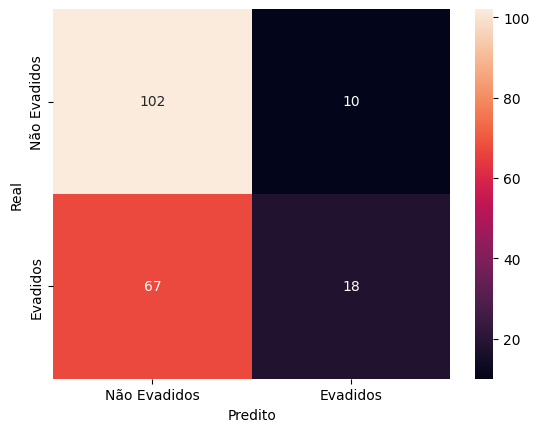

In [ ]:
matriz_confusao(y_test, predicoes_xgboost_computacao)

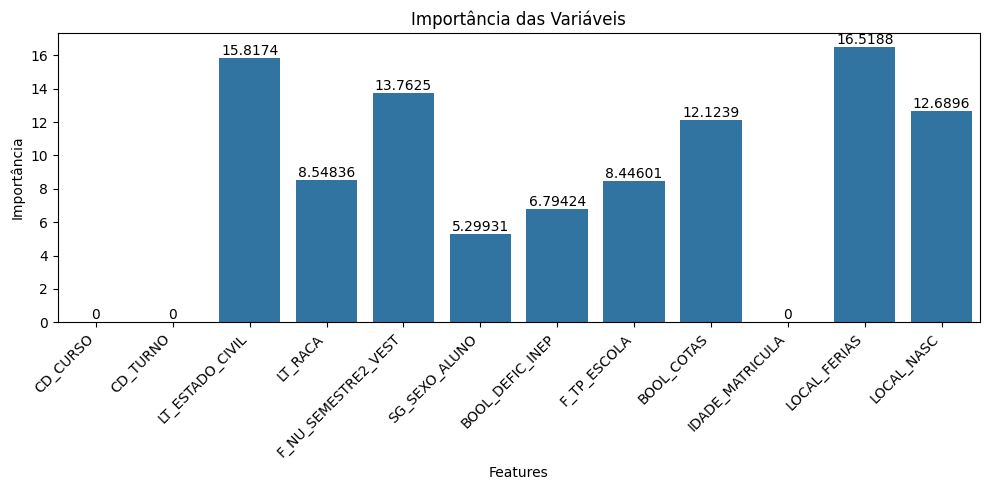

In [332]:
grafico_importancia_features(xgboost_computacao, X)

In [333]:
get_report(y_test, predicoes_xgboost_computacao)

              precision    recall  f1-score   support

         0.0       0.60      0.91      0.73       112
         1.0       0.64      0.21      0.32        85

    accuracy                           0.61       197
   macro avg       0.62      0.56      0.52       197
weighted avg       0.62      0.61      0.55       197



#### Informática

In [100]:
df[df['NM_CURSO'] == 'Informática']['CD_CURSO'].unique()

array([27], dtype=int64)

In [287]:
df_info = df[df['CD_CURSO'] == 27]

X = df_info.drop(colunas_excluir_ml, axis=1)
y = df_info[target_bool]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

len(X_train), len(X_test), sum(y_train), sum(y_test)

(759, 190, 398.0, 100.0)

In [272]:
df_info.shape[0]

949

In [273]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(BOOL_ST_ALUNO
 1.0    0.524374
 0.0    0.475626
 Name: proportion, dtype: float64,
 BOOL_ST_ALUNO
 1.0    0.526316
 0.0    0.473684
 Name: proportion, dtype: float64)

##### Baseline

In [118]:
get_baseline(y_test)

Acurácia : 0.7422680412371134
Precisão : 0.0
Recall : 0.0
f1_score : 0.0


c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7422680412371134, 0.0, 0.0, 0.0)

##### Árvore

In [103]:
arvore_info = treinar_modelo('arvore', X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [104]:
predicoes_arvore_info = get_predicoes(arvore_info, X_test)

In [105]:
get_parametros(arvore_info)

{'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [106]:
avaliar_modelo(y_test, predicoes_arvore_info)

Acurácia : 0.5736842105263158
Precisão : 0.6021505376344086
Recall : 0.56
f1_score : 0.5803108808290157


(0.5736842105263158, 0.6021505376344086, 0.56, 0.5803108808290157)

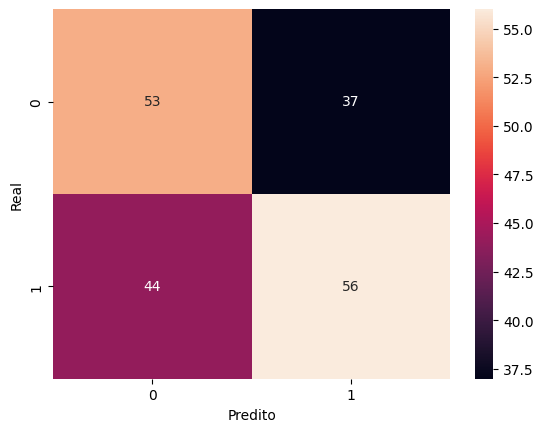

In [107]:
matriz_confusao(y_test, predicoes_arvore_info)

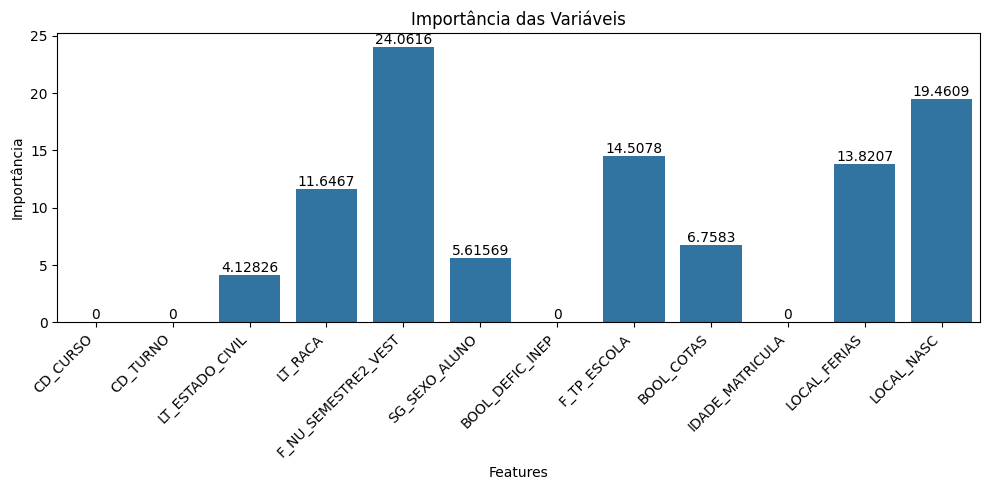

In [108]:
grafico_importancia_features(arvore_info, X)

In [290]:
get_report(y_test, predicoes_arvore_info)

              precision    recall  f1-score   support

         0.0       0.55      0.59      0.57        90
         1.0       0.60      0.56      0.58       100

    accuracy                           0.57       190
   macro avg       0.57      0.57      0.57       190
weighted avg       0.58      0.57      0.57       190



##### Floresta

In [110]:
floresta_info = treinar_modelo('floresta', X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [288]:
predicoes_floresta_info = get_predicoes(floresta_info, X_test)

In [112]:
get_parametros(floresta_info)

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [113]:
avaliar_modelo(y_test, predicoes_floresta_info)

Acurácia : 0.5157894736842106
Precisão : 0.5384615384615384
Recall : 0.56
f1_score : 0.5490196078431373


(0.5157894736842106, 0.5384615384615384, 0.56, 0.5490196078431373)

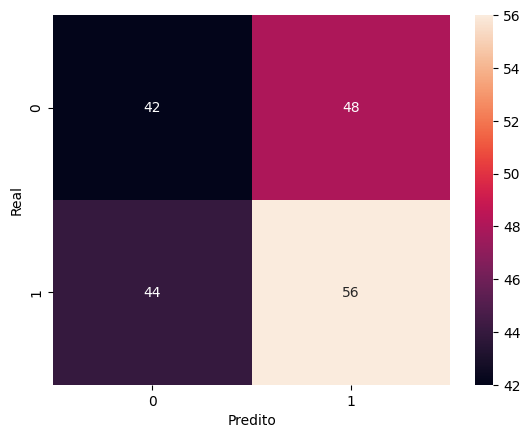

In [114]:
matriz_confusao(y_test, predicoes_floresta_info)

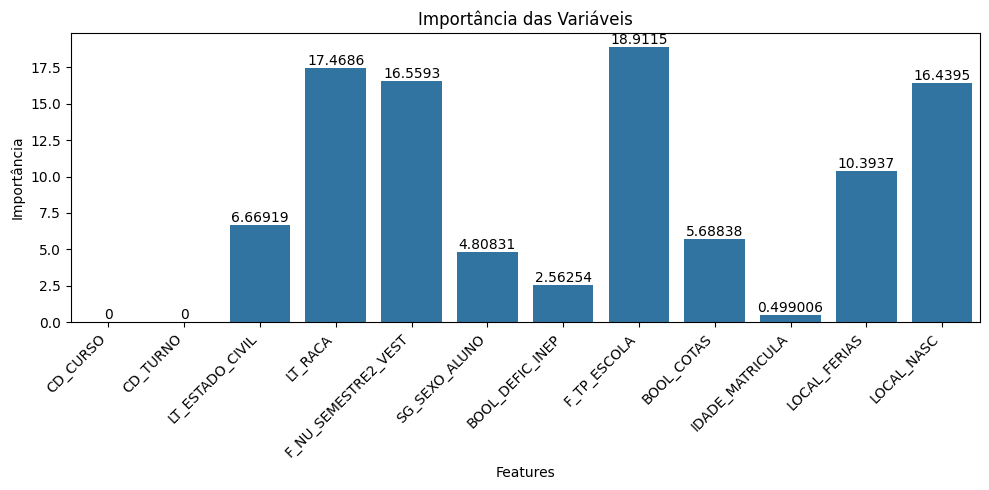

In [115]:
grafico_importancia_features(floresta_info, X)  

In [289]:
get_report(y_test, predicoes_floresta_info)

              precision    recall  f1-score   support

         0.0       0.49      0.47      0.48        90
         1.0       0.54      0.56      0.55       100

    accuracy                           0.52       190
   macro avg       0.51      0.51      0.51       190
weighted avg       0.51      0.52      0.52       190



##### XGBoost

In [264]:
xgboost_info = treinar_modelo('xgboost', X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [280]:
predicoes_xgboost_info = get_predicoes(xgboost_info, X_test)

In [266]:
get_parametros(xgboost_info)

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 200,
 'subsample': 1.0}

In [267]:
avaliar_modelo(y_test, predicoes_xgboost_info)

Acurácia : 0.6234939759036144
Precisão : 0.6394557823129252
Recall : 0.3230240549828179
f1_score : 0.42922374429223753


(0.6234939759036144,
 0.6394557823129252,
 0.3230240549828179,
 0.42922374429223753)

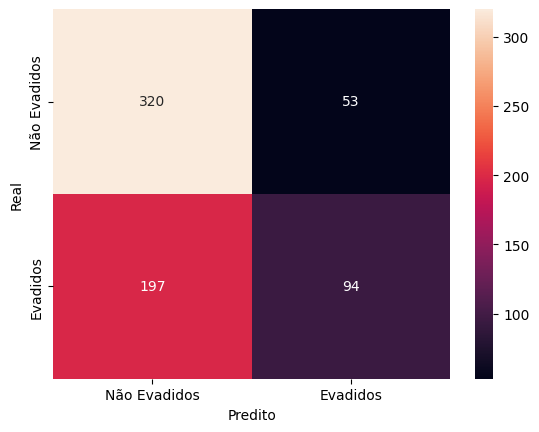

In [268]:
matriz_confusao(y_test, predicoes_xgboost_info)

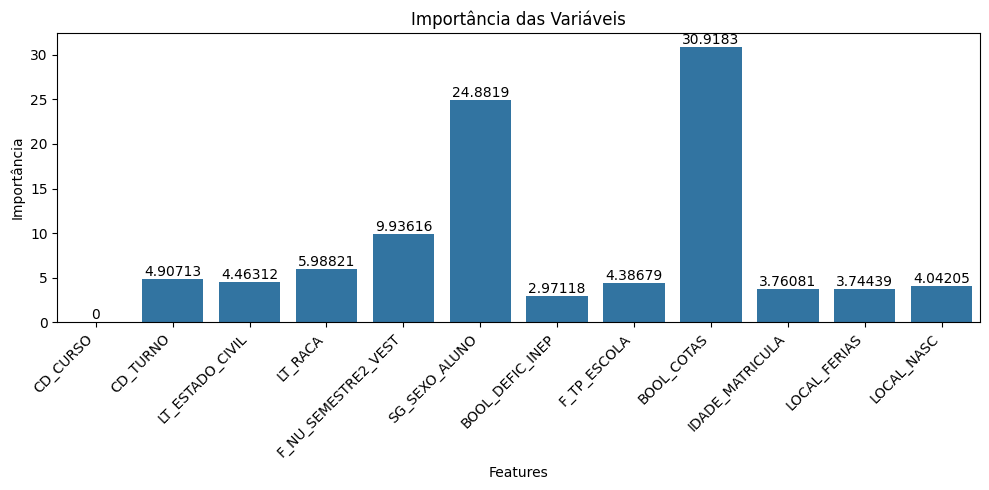

In [269]:
grafico_importancia_features(xgboost_info, X)

In [291]:
get_report(y_test, predicoes_xgboost_info)

              precision    recall  f1-score   support

         0.0       0.50      0.81      0.62        90
         1.0       0.62      0.28      0.39       100

    accuracy                           0.53       190
   macro avg       0.56      0.55      0.50       190
weighted avg       0.57      0.53      0.50       190



#### Letras

In [117]:
df[df['NM_CURSO'] == 'Letras']['CD_CURSO'].unique()

array([2], dtype=int64)

In [282]:
df_letras = df[df['CD_CURSO'] == 2]

X = df_letras.drop(colunas_excluir_ml, axis=1)
y = df_letras[target_bool]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

len(X_train), len(X_test), sum(y_train), sum(y_test)

(2654, 664, 1161.0, 291.0)

In [283]:
df_letras.shape[0]

3318

In [119]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(BOOL_ST_ALUNO
 0.0    0.562547
 1.0    0.437453
 Name: proportion, dtype: float64,
 BOOL_ST_ALUNO
 0.0    0.561747
 1.0    0.438253
 Name: proportion, dtype: float64)

##### Árvore

In [120]:
arvore_letras = treinar_modelo('arvore', X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [121]:
predicoes_arvore_letras = get_predicoes(arvore_letras, X_test)

In [122]:
get_parametros(arvore_letras)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20}

In [123]:
avaliar_modelo(y_test, predicoes_arvore_letras)

Acurácia : 0.5873493975903614
Precisão : 0.5521472392638037
Recall : 0.30927835051546393
f1_score : 0.39647577092511016


(0.5873493975903614,
 0.5521472392638037,
 0.30927835051546393,
 0.39647577092511016)

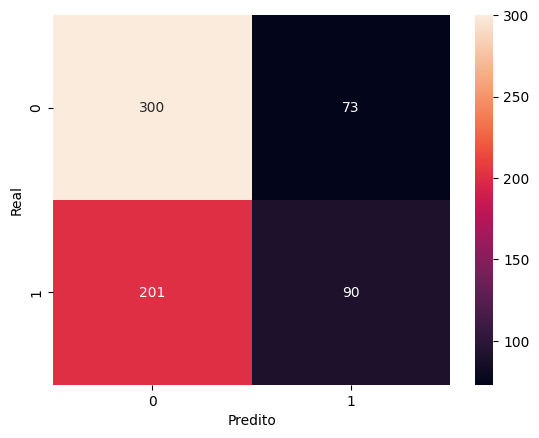

In [124]:
matriz_confusao(y_test, predicoes_arvore_letras)

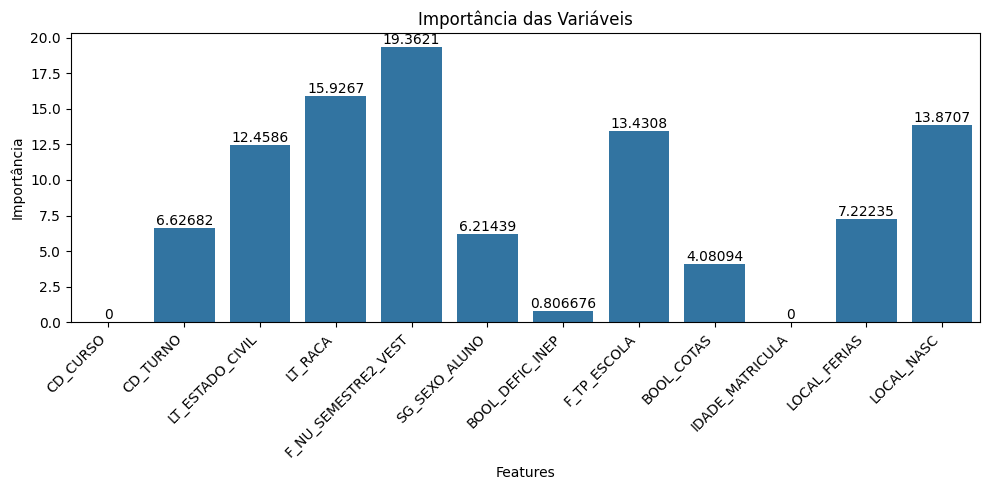

In [125]:
grafico_importancia_features(arvore_letras, X)

In [284]:
get_report(y_test, predicoes_arvore_letras)

              precision    recall  f1-score   support

         0.0       0.60      0.80      0.69       373
         1.0       0.55      0.31      0.40       291

    accuracy                           0.59       664
   macro avg       0.58      0.56      0.54       664
weighted avg       0.58      0.59      0.56       664



##### Floresta

In [127]:
floresta_letras = treinar_modelo('floresta', X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [128]:
predicoes_floresta_letras = get_predicoes(floresta_letras, X_test)

In [129]:
get_parametros(floresta_letras)

{'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'n_estimators': 100}

In [130]:
avaliar_modelo(y_test, predicoes_floresta_letras)

Acurácia : 0.6129518072289156
Precisão : 0.6024096385542169
Recall : 0.3436426116838488
f1_score : 0.43763676148796504


(0.6129518072289156,
 0.6024096385542169,
 0.3436426116838488,
 0.43763676148796504)

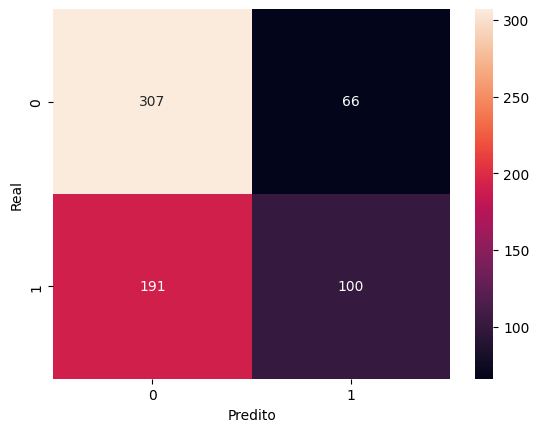

In [131]:
matriz_confusao(y_test, predicoes_floresta_letras)

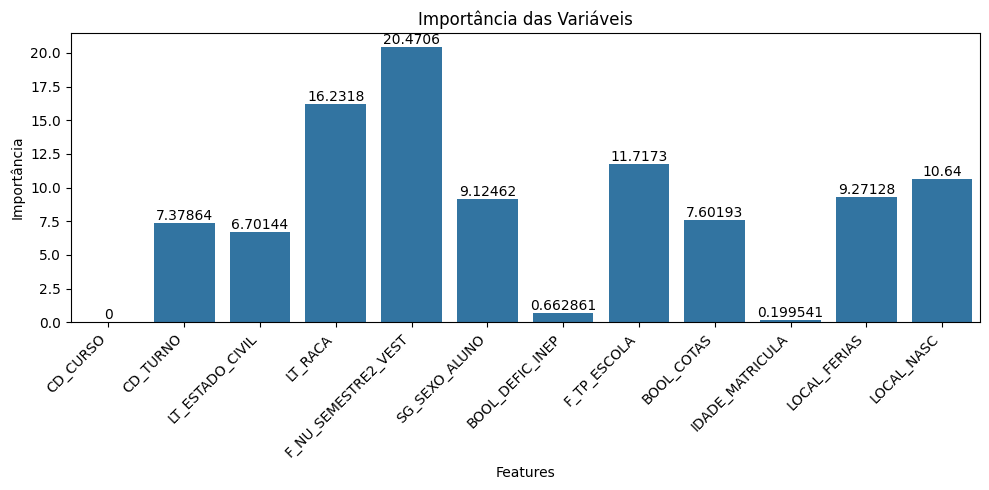

In [132]:
grafico_importancia_features(floresta_letras, X)

In [285]:
get_report(y_test, predicoes_floresta_letras)

              precision    recall  f1-score   support

         0.0       0.62      0.82      0.70       373
         1.0       0.60      0.34      0.44       291

    accuracy                           0.61       664
   macro avg       0.61      0.58      0.57       664
weighted avg       0.61      0.61      0.59       664



##### XGBoost

In [134]:
xgboost_letras = treinar_modelo('xgboost', X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [135]:
predicoes_xgboost_letras = get_predicoes(xgboost_letras, X_test)

In [136]:
get_parametros(xgboost_letras)

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 200,
 'subsample': 1.0}

In [137]:
avaliar_modelo(y_test, predicoes_xgboost_letras)

Acurácia : 0.6234939759036144
Precisão : 0.6394557823129252
Recall : 0.3230240549828179
f1_score : 0.42922374429223753


(0.6234939759036144,
 0.6394557823129252,
 0.3230240549828179,
 0.42922374429223753)

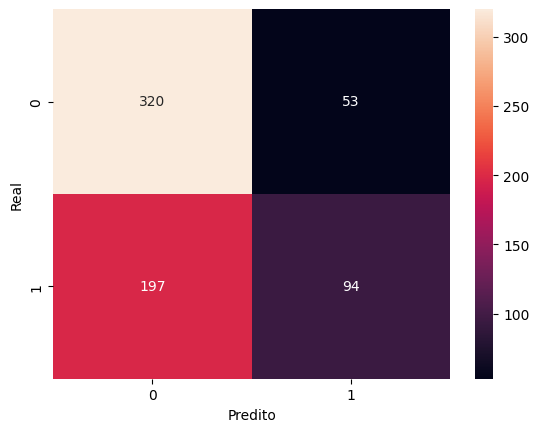

In [138]:
matriz_confusao(y_test, predicoes_xgboost_letras)

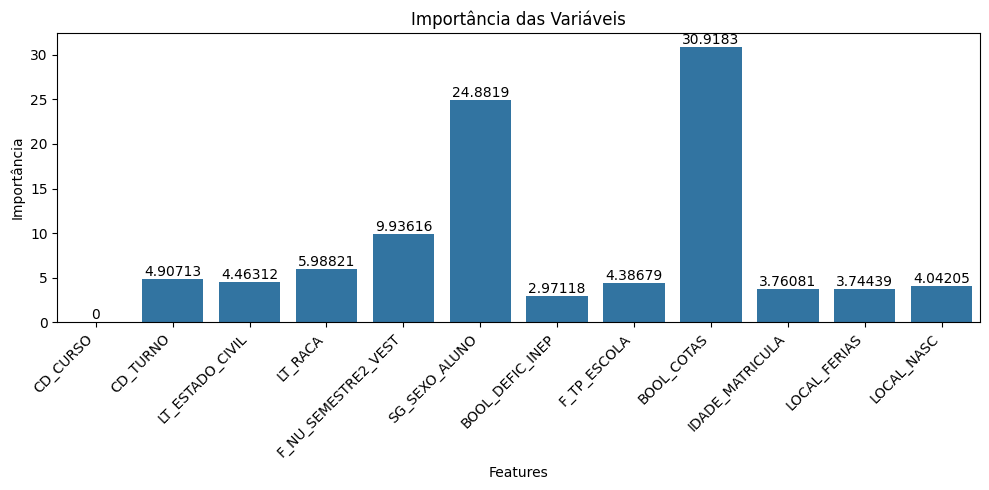

In [139]:
grafico_importancia_features(xgboost_letras, X)

In [286]:
get_report(y_test, predicoes_xgboost_letras)

              precision    recall  f1-score   support

         0.0       0.62      0.86      0.72       373
         1.0       0.64      0.32      0.43       291

    accuracy                           0.62       664
   macro avg       0.63      0.59      0.57       664
weighted avg       0.63      0.62      0.59       664



### Oversampling

In [141]:
X = df.drop(colunas_excluir_ml, axis=1)
y = df[target_bool]

In [142]:
len(X)

66820

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
len(X_train), len(X_test)

(53456, 13364)

In [144]:
X_train_over, y_train_over = oversample(X_train, y_train)
len(X_train_over)

67980

In [145]:
y_train_over.value_counts()

BOOL_ST_ALUNO
0.0    33990
1.0    33990
Name: count, dtype: int64

#### Baseline

In [146]:
y_pred_over = np.zeros(len(y_test))

avaliar_modelo(y_test, y_pred_over)

Acurácia : 0.6358126309488177
Precisão : 0.0
Recall : 0.0
f1_score : 0.0


c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.6358126309488177, 0.0, 0.0, 0.0)

#### Árvore

In [147]:
modelo_arvore_oversampling = treinar_modelo('arvore', X_train_over, y_train_over)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [148]:
predicoes_arvore_oversampling = get_predicoes(modelo_arvore_oversampling, X_test)

In [149]:
get_parametros(modelo_arvore_oversampling)

{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [150]:
avaliar_modelo(y_test, predicoes_arvore_oversampling)

Acurácia : 0.6132146064052679
Precisão : 0.4716058668672433
Recall : 0.51530717074173
f1_score : 0.4924889543446244


(0.6132146064052679, 0.4716058668672433, 0.51530717074173, 0.4924889543446244)

Recall melhorou bastante!

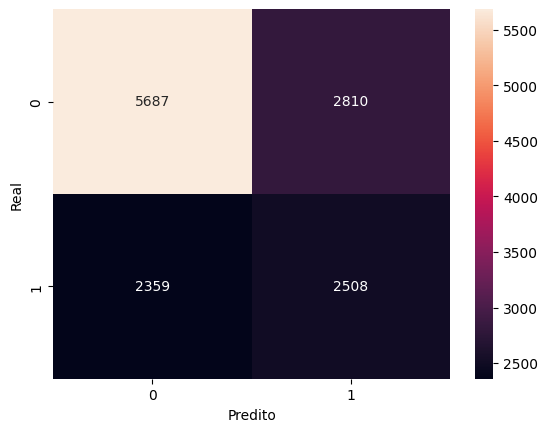

In [151]:
matriz_confusao(y_test, predicoes_arvore_oversampling)

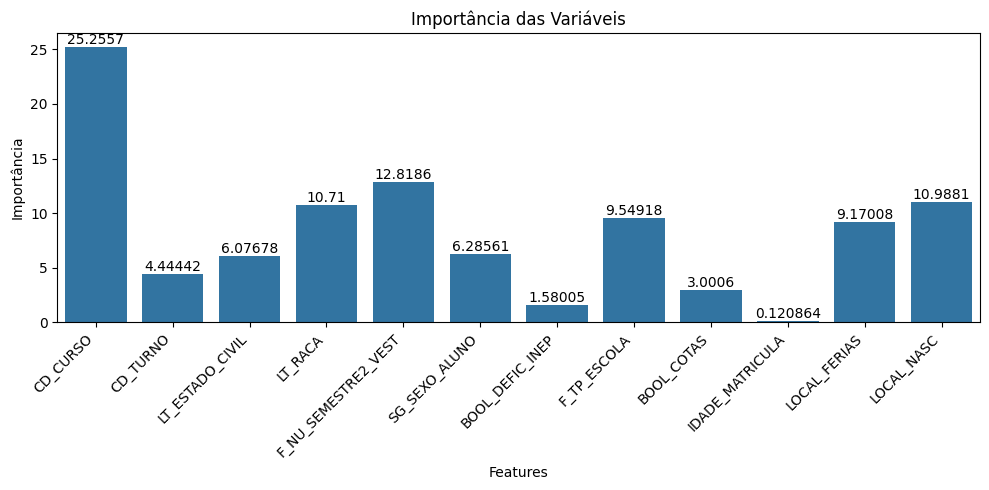

In [152]:
grafico_importancia_features(modelo_arvore_oversampling, X)

In [153]:
get_report(y_test, predicoes_arvore_oversampling)

              precision    recall  f1-score   support

         0.0       0.71      0.67      0.69      8497
         1.0       0.47      0.52      0.49      4867

    accuracy                           0.61     13364
   macro avg       0.59      0.59      0.59     13364
weighted avg       0.62      0.61      0.62     13364



#### Floresta

In [154]:
modelo_floresta_oversampling = treinar_modelo('floresta', X_train_over, y_train_over)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [155]:
predicoes_floresta_oversampling = get_predicoes(modelo_floresta_oversampling, X_test)

In [156]:
get_parametros(modelo_floresta_oversampling)

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

In [157]:
avaliar_modelo(y_test, predicoes_floresta_oversampling)

Acurácia : 0.623091888656091
Precisão : 0.48484848484848486
Recall : 0.5588658311074584
f1_score : 0.5192326047532692


(0.623091888656091,
 0.48484848484848486,
 0.5588658311074584,
 0.5192326047532692)

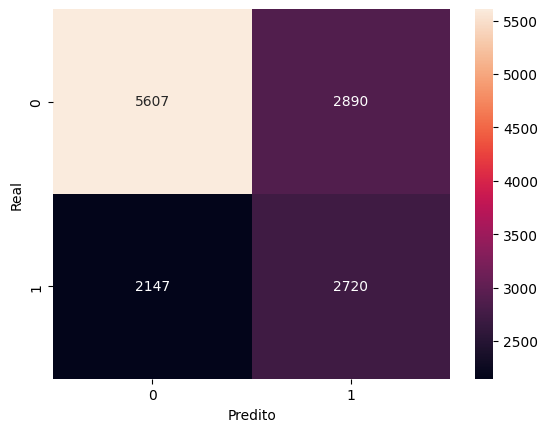

In [158]:
matriz_confusao(y_test, predicoes_floresta_oversampling)

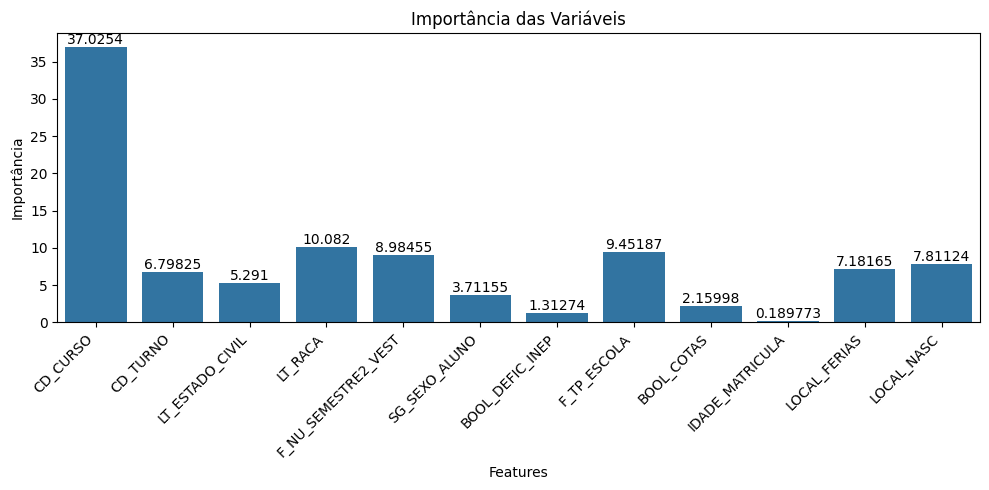

In [159]:
grafico_importancia_features(modelo_floresta_oversampling, X)

In [160]:
get_report(y_test, predicoes_floresta_oversampling)

              precision    recall  f1-score   support

         0.0       0.72      0.66      0.69      8497
         1.0       0.48      0.56      0.52      4867

    accuracy                           0.62     13364
   macro avg       0.60      0.61      0.60     13364
weighted avg       0.64      0.62      0.63     13364



#### XGBoost

In [161]:
xgboost_oversampling = treinar_modelo('xgboost', X_train_over, y_train_over)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [162]:
predicoes_xgboost_oversampling = get_predicoes(xgboost_oversampling, X_test)

In [163]:
get_parametros(xgboost_oversampling)

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 20,
 'n_estimators': 100,
 'subsample': 1.0}

In [164]:
avaliar_modelo(y_test, predicoes_xgboost_oversampling)

Acurácia : 0.6348398683029033
Precisão : 0.49888104665174726
Recall : 0.5954386685843436
f1_score : 0.5428999625327837


(0.6348398683029033,
 0.49888104665174726,
 0.5954386685843436,
 0.5428999625327837)

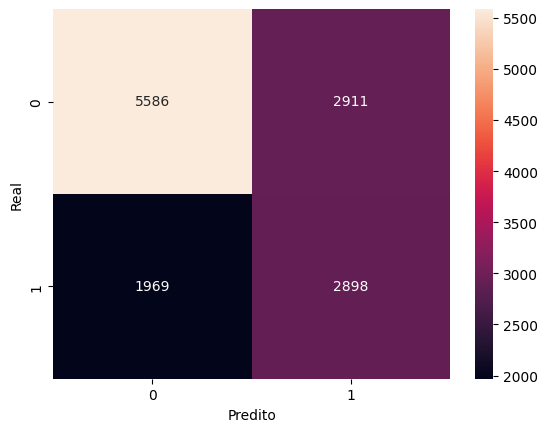

In [165]:
matriz_confusao(y_test, predicoes_xgboost_oversampling)

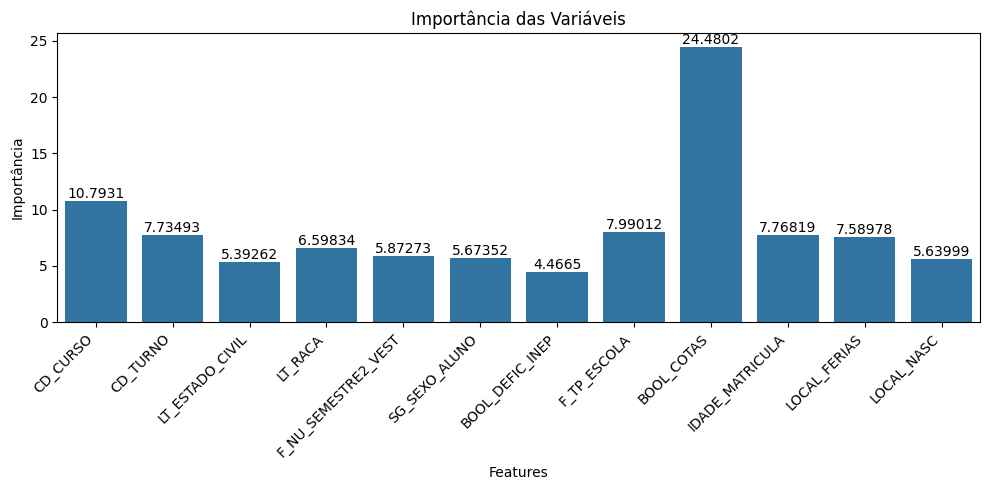

In [166]:
grafico_importancia_features(xgboost_oversampling, X)

In [167]:
get_report(y_test, predicoes_floresta_oversampling)

              precision    recall  f1-score   support

         0.0       0.72      0.66      0.69      8497
         1.0       0.48      0.56      0.52      4867

    accuracy                           0.62     13364
   macro avg       0.60      0.61      0.60     13364
weighted avg       0.64      0.62      0.63     13364



### Undersampling

In [168]:
X = df.drop(colunas_excluir_ml, axis=1)
y = df[target_bool]

len(X)

66820

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
len(X_train), len(X_test)

(53456, 13364)

In [170]:
X_train_under, y_train_under = undersample(X_train, y_train)
len(X_train_under)

38932

In [171]:
y_train_under.value_counts()

BOOL_ST_ALUNO
0.0    19466
1.0    19466
Name: count, dtype: int64

#### Baseline

In [50]:
y_pred_under = np.zeros(len(y_test))

avaliar_modelo(y_test, y_pred_under)

Acurácia : 0.6358126309488177
Precisão : 0.0
Recall : 0.0
f1_score : 0.0


c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.6358126309488177, 0.0, 0.0, 0.0)

#### Árvore

In [172]:
arvore_undersampling = treinar_modelo('arvore', X_train_under, y_train_under)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [173]:
predicoes_arvore_undersampling = get_predicoes(arvore_undersampling, X_test)

In [174]:
get_parametros(arvore_undersampling)

{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}

In [175]:
avaliar_modelo(y_test, predicoes_arvore_undersampling)

Acurácia : 0.615983238551332
Precisão : 0.47850770478507704
Recall : 0.606122868296692
f1_score : 0.5348078317621464


(0.615983238551332, 0.47850770478507704, 0.606122868296692, 0.5348078317621464)

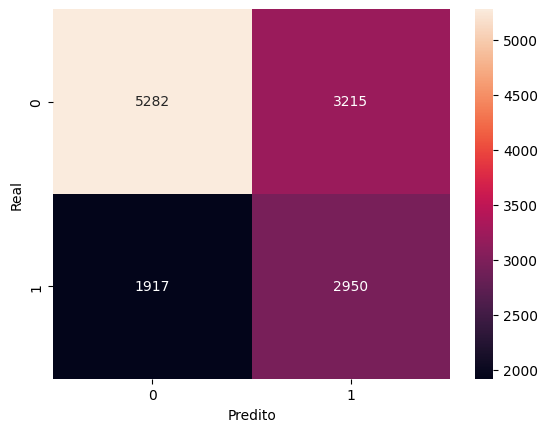

In [176]:
matriz_confusao(y_test, predicoes_arvore_undersampling)

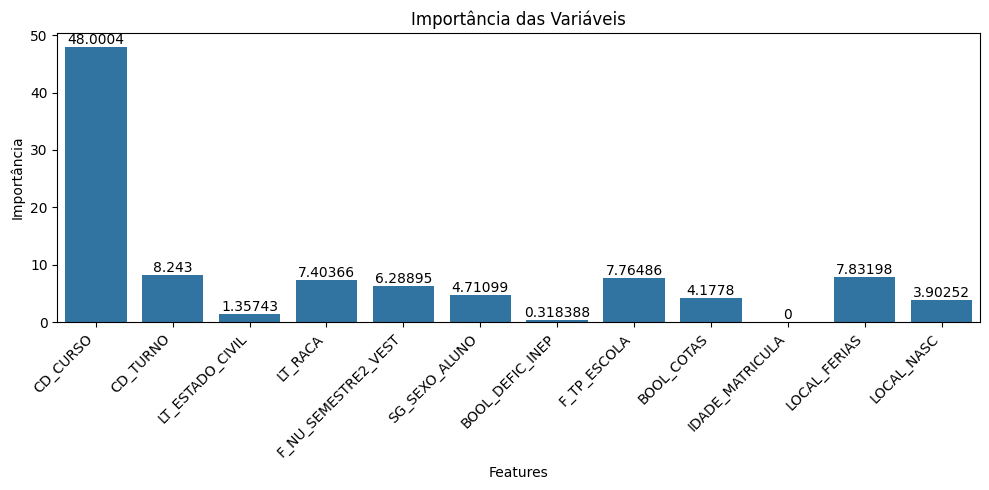

In [177]:
grafico_importancia_features(arvore_undersampling, X)

In [178]:
get_report(y_test, predicoes_arvore_undersampling)

              precision    recall  f1-score   support

         0.0       0.73      0.62      0.67      8497
         1.0       0.48      0.61      0.53      4867

    accuracy                           0.62     13364
   macro avg       0.61      0.61      0.60     13364
weighted avg       0.64      0.62      0.62     13364



#### Floresta

In [179]:
floresta_undersampling = treinar_modelo('floresta', X_train_under, y_train_under)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [180]:
predicoes_floresta_undersampling = get_predicoes(floresta_undersampling, X_test)

In [181]:
get_parametros(floresta_undersampling)

{'max_depth': 30,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'n_estimators': 200}

In [182]:
avaliar_modelo(y_test, predicoes_floresta_undersampling)

Acurácia : 0.6247381023645615
Precisão : 0.4884699283265815
Recall : 0.6441339634271626
f1_score : 0.5556047851129818


(0.6247381023645615,
 0.4884699283265815,
 0.6441339634271626,
 0.5556047851129818)

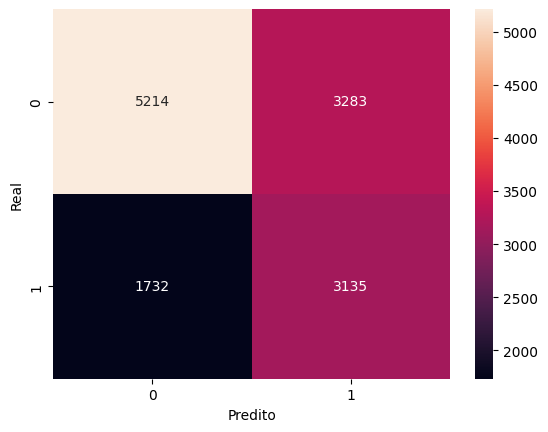

In [183]:
matriz_confusao(y_test, predicoes_floresta_undersampling)

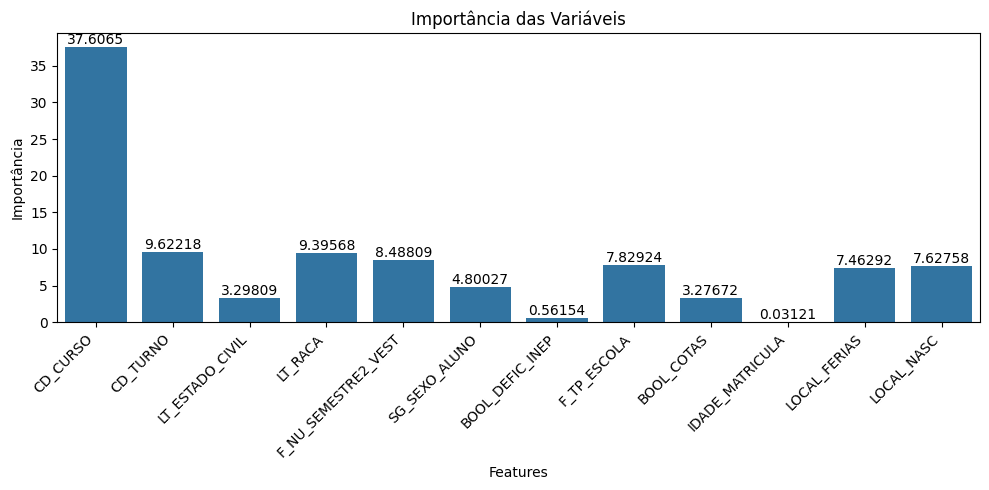

In [184]:
grafico_importancia_features(floresta_undersampling, X)

In [185]:
get_report(y_test, predicoes_floresta_undersampling)

              precision    recall  f1-score   support

         0.0       0.75      0.61      0.68      8497
         1.0       0.49      0.64      0.56      4867

    accuracy                           0.62     13364
   macro avg       0.62      0.63      0.62     13364
weighted avg       0.66      0.62      0.63     13364



#### XGBoost

In [186]:
xgboost_undersampling = treinar_modelo('xgboost', X_train_under, y_train_under)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [187]:
predicoes_xgboost_undersampling = get_predicoes(xgboost_undersampling, X_test)

In [188]:
get_parametros(xgboost_undersampling)

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 50,
 'subsample': 1.0}

In [189]:
avaliar_modelo(y_test, predicoes_xgboost_undersampling)

Acurácia : 0.6376085004489673
Precisão : 0.5019261637239165
Recall : 0.6424902403944935
f1_score : 0.563575741191313


(0.6376085004489673, 0.5019261637239165, 0.6424902403944935, 0.563575741191313)

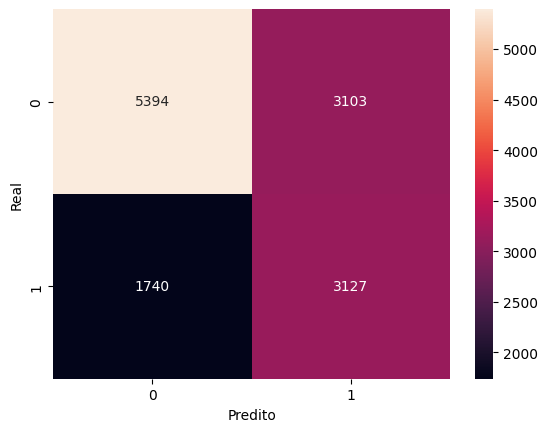

In [190]:
matriz_confusao(y_test, predicoes_xgboost_undersampling)

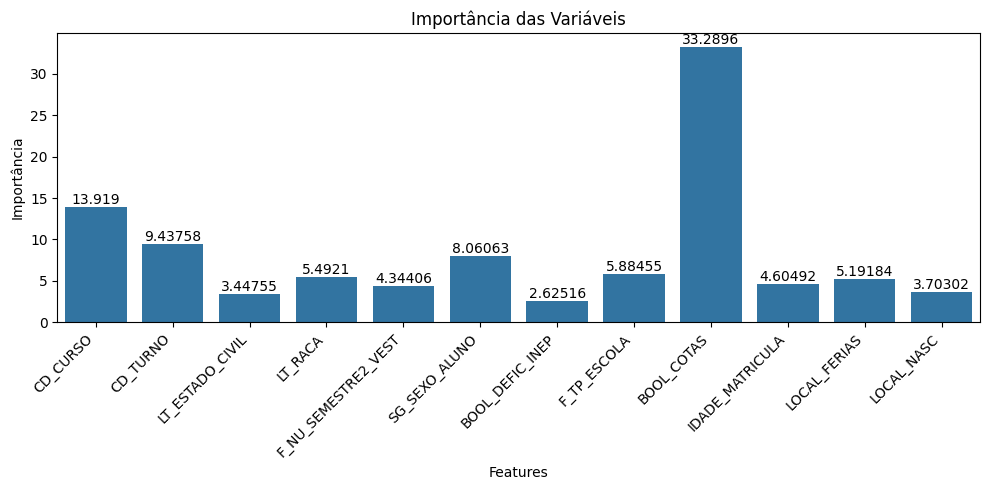

In [191]:
grafico_importancia_features(xgboost_undersampling, X)

In [192]:
get_report(y_test, predicoes_xgboost_undersampling)

              precision    recall  f1-score   support

         0.0       0.76      0.63      0.69      8497
         1.0       0.50      0.64      0.56      4867

    accuracy                           0.64     13364
   macro avg       0.63      0.64      0.63     13364
weighted avg       0.66      0.64      0.64     13364



### Undersampling Gerações Completas

In [193]:
df_geracoes_completas = df[df['GERACAO_COMPLETA'] == 1]
df_geracoes_completas.shape[0]

42249

In [194]:
df_geracoes_completas['BOOL_ST_ALUNO'].value_counts(), df_geracoes_completas['BOOL_ST_ALUNO'].value_counts(normalize=True)

(BOOL_ST_ALUNO
 0.0    27111
 1.0    15138
 Name: count, dtype: int64,
 BOOL_ST_ALUNO
 0.0    0.641696
 1.0    0.358304
 Name: proportion, dtype: float64)

In [195]:
X = df_geracoes_completas.drop(colunas_excluir_ml, axis=1)
y = df_geracoes_completas[target_bool]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
len(X_train), len(X_test), sum(y_train), sum(y_test)

(33799, 8450, 12110.0, 3028.0)

In [196]:
X_train, y_train = undersample(X_train, y_train)

In [197]:
len(X_train)

24220

In [198]:
y_train.value_counts()

BOOL_ST_ALUNO
0.0    12110
1.0    12110
Name: count, dtype: int64

#### Baseline

In [36]:
get_baseline(y_test)

Acurácia : 0.6416568047337278
Precisão : 0.0
Recall : 0.0
f1_score : 0.0


c:\Users\romulo.mincache\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.6416568047337278, 0.0, 0.0, 0.0)

#### Árvore

In [ ]:
arvore_undersampling_gc = treinar_modelo()